In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

#Preprocessing
from sklearn.preprocessing import MinMaxScaler,StandardScaler

#Metric-utils
from sklearn.metrics import confusion_matrix, roc_auc_score, roc_curve,accuracy_score
from sklearn.utils.class_weight import compute_class_weight

#Feature Importance
import shap
from boruta import BorutaPy

#Classifier-utils
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split 
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import LeaveOneOut


#Imbalanced Learning
from imblearn.combine import SMOTEENN
from imblearn.over_sampling import SMOTE, ADASYN,SMOTENC, BorderlineSMOTE,SVMSMOTE,KMeansSMOTE
from imblearn.over_sampling import RandomOverSampler

In [3]:
df=pd.read_csv('/users/emanueleamato/Desktop/PHD_Projects/Eco/Dataset/AnalisiPaper/4CHES/Medium vs Poor/Medium_Poor.csv')

### DataFrame Preprocessing Steps:
- Scale the values between 0 and 1.
- As you're using SVM and not Random Forest, you won't use Boruta for feature selection but rather feature importance with shap.
- Disclaimer: To perform feature importance with SHAP, you need to save the vector of feature names (columns) to use them in the final plots.

### Feature Names Vector:
- Save the vector of feature names to use in SHAP plots for interpretation and analysis.

In [17]:
df_filtered_normalized = df_filtered.copy()
x = df_filtered.iloc[:, 2:]
scaler = MinMaxScaler(feature_range=(0, 1))
x_scaled = scaler.fit_transform(x)


- x_scaled transforms the df structure in a numpy array
- I need to overwrite the past df with the normalized values between 0 and 1

In [18]:
df_filtered_normalized.iloc[:, 2:] = x_scaled
feature_names = df_filtered.columns[2:].tolist()
print(feature_names)

['contrast_0°', 'energy_0°', 'homogeneity_0°', 'correlation_0°', 'dissimilarity_0°', 'contrast_45°', 'energy_45°', 'homogeneity_45°', 'correlation_45°', 'dissimilarity_45°', 'contrast_90°', 'energy_90°', 'homogeneity_90°', 'correlation_90°', 'dissimilarity_90°', 'contrast_135°', 'energy_135°', 'homogeneity_135°', 'correlation_135°', 'dissimilarity_135°', 'hist_mean', 'hist_std', 'hist_skewness', 'hist_kurtosis', 'hist_maximum', 'hist_variance', 'hist_percentile_50', 'hist_percentile_75', 'hist_entropy', 'hist_uniformity']


In [23]:
df_filtered_normalized.iloc[:, 2:]

,contrast_0°,energy_0°,homogeneity_0°,correlation_0°,dissimilarity_0°,contrast_45°,energy_45°,homogeneity_45°,correlation_45°,dissimilarity_45°,...,hist_mean,hist_std,hist_skewness,hist_kurtosis,hist_maximum,hist_variance,hist_percentile_50,hist_percentile_75,hist_entropy,hist_uniformity
0,0.339666,0.371844,0.226218,0.396907,0.544944,0.601980,0.370977,0.190975,0.159555,0.747622,...,0.334741,0.341598,0.700462,0.702132,0.925926,0.241824,0.275229,0.354839,0.605140,0.369944
1,0.875306,0.019617,0.000000,0.541211,1.000000,0.973651,0.018911,0.000000,0.614536,1.000000,...,0.744011,0.760287,0.918463,0.919067,1.000000,0.679437,0.568807,0.733871,1.000000,0.000000
2,0.181515,0.532672,0.367798,0.430657,0.333344,0.212659,0.535878,0.309063,0.518432,0.391809,...,0.286285,0.227024,0.419768,0.421400,0.629630,0.149175,0.330275,0.314516,0.289647,0.561691
3,0.455992,0.956833,0.519171,0.766206,0.332049,0.461365,0.960272,0.406297,0.853048,0.506517,...,0.661458,0.615863,0.718166,0.720267,0.888889,0.510913,0.669725,0.725806,0.294996,0.968986
4,0.293546,0.521735,0.376666,0.412425,0.351922,0.251562,0.522385,0.316999,0.641083,0.395431,...,0.393208,0.312601,0.580010,0.582476,0.518519,0.217275,0.412844,0.443548,0.360359,0.533870
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
207,0.243770,0.510419,0.396772,0.618152,0.293752,0.326276,0.510290,0.318021,0.609670,0.406704,...,0.431399,0.355001,0.542987,0.545369,0.703704,0.253423,0.467890,0.467742,0.353175,0.525532
208,0.459135,0.522762,0.284010,0.592703,0.491317,0.523688,0.521833,0.245427,0.650005,0.591701,...,0.602850,0.516765,0.617540,0.620315,0.592593,0.405984,0.623853,0.661290,0.375202,0.531078
209,0.393509,0.526661,0.319785,0.544200,0.453485,0.420595,0.525872,0.295945,0.646879,0.534697,...,0.500870,0.443571,0.679519,0.681766,0.962963,0.334078,0.486239,0.548387,0.467582,0.528381
210,0.046799,0.557269,0.535173,0.413801,0.122572,0.021382,0.555874,0.455585,0.622017,0.133084,...,0.155855,0.096065,0.465908,0.468176,0.333333,0.057542,0.192661,0.217742,0.255194,0.580074


**One hot encoding**

In [20]:
#Filtro sul nuovo dataset facendo ONEHOT su df_filtered
y=df_filtered_normalized["ImageQuality"]
y_encoded=pd.get_dummies(y)
y=np.argmax(y_encoded.values, axis=1)
np.bincount(y)
print(np.bincount(y))
#0->Medium
#1->Poor

[165  47]


**SKF_SVM_SHAP**

In [98]:
num_samples = len(x_scaled)
num_folds = 5

shap_values_dict = {}
confusion_matrices = {}

for seed in range(100):
    
    skf = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=seed)
    
    y_test_tot = []
    y_pred_tot = []
    shap_values_tot = []
    
    confusion_matrices[seed] = [] 
    print("Iterazione:", seed+1)
    print(f'0->Medium, 1->Poor\n')
    
    for i, (train_index, test_index) in enumerate(skf.split(x_scaled, y)):
        
        oversample = SMOTE(random_state=seed,k_neighbors=5)
        
        X_train, X_test = x_scaled[train_index], x_scaled[test_index]
        y_train, y_test = y[train_index], y[test_index]
        
        print(f'Prima:', np.unique(y_train, return_counts=True))
        X_train, y_train = oversample.fit_resample(X_train, y_train)
        print(f'Dopo:', np.unique(y_train, return_counts=True))
        
        print(len(X_train), len(y_train))
        
        #SVM Classifier
        svm_classifier = svm.SVC(kernel='linear', decision_function_shape='ovr', probability=True, random_state=seed)
        svm_classifier.fit(X_train, y_train)
        y_pred_test = svm_classifier.predict(X_test)
       
        # Calcola SHAP values per le predizioni
        
        ## Problema: Shap vuole in ingresso KernelExplainer di SHAP il quale attende 
        ## una funzione di predizione che restituisce le previsioni dirette, non le probabilità delle classi.
        ## Forse va usato il np.argmax, axis=1 (se le predizioni sono in riga)
        
        explainer   = shap.KernelExplainer(svm_classifier.predict_proba, X_train ,feature_names=feature_names)
        shap_values = explainer.shap_values(X_test)
   
    
        # Estendo le previsioni e gli SHAP values
        y_test_tot.extend(y_test)
        y_pred_tot.extend(y_pred_test)
        shap_values_tot.append(np.array(shap_values))
        
    # Calcola la media degli SHAP values di tutte le fold del seed fissato
    # shap_values_mean = np.mean(shap_values_tot, axis=0)
    # Dimensione degli SHAP values per seed 0: (2, 2, 106, 30) -> Devo ovviare alla presenza di questo errore
    
    shap_values_combined = np.concatenate(shap_values_tot, axis=1)
    print(f"Dimensione degli SHAP values per seed {seed}: {np.array(shap_values_combined).shape}")
    shap_values_dict[seed] = shap_values_combined

    
    # Calcola la matrice di confusione per questa iterazione
    cm = confusion_matrix(y_test_tot, y_pred_tot)
    confusion_matrices[seed].append(cm)
    
    # Calcola sensitivity e specificity
    TP = cm[0, 0]  
    FN = cm[0, 1]  
    TN = cm[1, 1]  
    FP = cm[1, 0]  
    
    sensitivity = TP / (TP + FN)    
    specificity = TN / (TN + FP)

    print("Sensitivity:", sensitivity)
    print("Specificity:", specificity)
    print("Matrice di confusione per il seed", seed+1, ":")
    print(cm)
   


Using 264 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


Iterazione: 1
0->Medium, 1->Poor

Prima: (array([0, 1]), array([132,  37]))
Dopo: (array([0, 1]), array([132, 132]))
264 264


  0%|          | 0/43 [00:00<?, ?it/s]

Using 264 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


Prima: (array([0, 1]), array([132,  37]))
Dopo: (array([0, 1]), array([132, 132]))
264 264


  0%|          | 0/43 [00:00<?, ?it/s]

Using 264 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


Prima: (array([0, 1]), array([132,  38]))
Dopo: (array([0, 1]), array([132, 132]))
264 264


  0%|          | 0/42 [00:00<?, ?it/s]

Using 264 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


Prima: (array([0, 1]), array([132,  38]))
Dopo: (array([0, 1]), array([132, 132]))
264 264


  0%|          | 0/42 [00:00<?, ?it/s]

Using 264 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


Prima: (array([0, 1]), array([132,  38]))
Dopo: (array([0, 1]), array([132, 132]))
264 264


  0%|          | 0/42 [00:00<?, ?it/s]

Using 264 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


Dimensione degli SHAP values per seed 0: (2, 212, 30)
Sensitivity: 0.5878787878787879
Specificity: 0.46808510638297873
Matrice di confusione per il seed 1 :
[[97 68]
 [25 22]]
Iterazione: 2
0->Medium, 1->Poor

Prima: (array([0, 1]), array([132,  37]))
Dopo: (array([0, 1]), array([132, 132]))
264 264


  0%|          | 0/43 [00:00<?, ?it/s]

Using 264 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


Prima: (array([0, 1]), array([132,  37]))
Dopo: (array([0, 1]), array([132, 132]))
264 264


  0%|          | 0/43 [00:00<?, ?it/s]

Using 264 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


Prima: (array([0, 1]), array([132,  38]))
Dopo: (array([0, 1]), array([132, 132]))
264 264


  0%|          | 0/42 [00:00<?, ?it/s]

Using 264 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


Prima: (array([0, 1]), array([132,  38]))
Dopo: (array([0, 1]), array([132, 132]))
264 264


  0%|          | 0/42 [00:00<?, ?it/s]

Using 264 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


Prima: (array([0, 1]), array([132,  38]))
Dopo: (array([0, 1]), array([132, 132]))
264 264


  0%|          | 0/42 [00:00<?, ?it/s]

Using 264 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


Dimensione degli SHAP values per seed 1: (2, 212, 30)
Sensitivity: 0.6060606060606061
Specificity: 0.3404255319148936
Matrice di confusione per il seed 2 :
[[100  65]
 [ 31  16]]
Iterazione: 3
0->Medium, 1->Poor

Prima: (array([0, 1]), array([132,  37]))
Dopo: (array([0, 1]), array([132, 132]))
264 264


  0%|          | 0/43 [00:00<?, ?it/s]

Using 264 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


Prima: (array([0, 1]), array([132,  37]))
Dopo: (array([0, 1]), array([132, 132]))
264 264


  0%|          | 0/43 [00:00<?, ?it/s]

Using 264 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


Prima: (array([0, 1]), array([132,  38]))
Dopo: (array([0, 1]), array([132, 132]))
264 264


  0%|          | 0/42 [00:00<?, ?it/s]

Using 264 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


Prima: (array([0, 1]), array([132,  38]))
Dopo: (array([0, 1]), array([132, 132]))
264 264


  0%|          | 0/42 [00:00<?, ?it/s]

Using 264 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


Prima: (array([0, 1]), array([132,  38]))
Dopo: (array([0, 1]), array([132, 132]))
264 264


  0%|          | 0/42 [00:00<?, ?it/s]

Using 264 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


Dimensione degli SHAP values per seed 2: (2, 212, 30)
Sensitivity: 0.5878787878787879
Specificity: 0.425531914893617
Matrice di confusione per il seed 3 :
[[97 68]
 [27 20]]
Iterazione: 4
0->Medium, 1->Poor

Prima: (array([0, 1]), array([132,  37]))
Dopo: (array([0, 1]), array([132, 132]))
264 264


  0%|          | 0/43 [00:00<?, ?it/s]

Using 264 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


Prima: (array([0, 1]), array([132,  37]))
Dopo: (array([0, 1]), array([132, 132]))
264 264


  0%|          | 0/43 [00:00<?, ?it/s]

Using 264 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


Prima: (array([0, 1]), array([132,  38]))
Dopo: (array([0, 1]), array([132, 132]))
264 264


  0%|          | 0/42 [00:00<?, ?it/s]

Using 264 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


Prima: (array([0, 1]), array([132,  38]))
Dopo: (array([0, 1]), array([132, 132]))
264 264


  0%|          | 0/42 [00:00<?, ?it/s]

Using 264 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


Prima: (array([0, 1]), array([132,  38]))
Dopo: (array([0, 1]), array([132, 132]))
264 264


  0%|          | 0/42 [00:00<?, ?it/s]

Using 264 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


Dimensione degli SHAP values per seed 3: (2, 212, 30)
Sensitivity: 0.6181818181818182
Specificity: 0.46808510638297873
Matrice di confusione per il seed 4 :
[[102  63]
 [ 25  22]]
Iterazione: 5
0->Medium, 1->Poor

Prima: (array([0, 1]), array([132,  37]))
Dopo: (array([0, 1]), array([132, 132]))
264 264


  0%|          | 0/43 [00:00<?, ?it/s]

Using 264 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


Prima: (array([0, 1]), array([132,  37]))
Dopo: (array([0, 1]), array([132, 132]))
264 264


  0%|          | 0/43 [00:00<?, ?it/s]

Using 264 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


Prima: (array([0, 1]), array([132,  38]))
Dopo: (array([0, 1]), array([132, 132]))
264 264


  0%|          | 0/42 [00:00<?, ?it/s]

Using 264 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


Prima: (array([0, 1]), array([132,  38]))
Dopo: (array([0, 1]), array([132, 132]))
264 264


  0%|          | 0/42 [00:00<?, ?it/s]

Using 264 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


Prima: (array([0, 1]), array([132,  38]))
Dopo: (array([0, 1]), array([132, 132]))
264 264


  0%|          | 0/42 [00:00<?, ?it/s]

Using 264 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


Dimensione degli SHAP values per seed 4: (2, 212, 30)
Sensitivity: 0.6363636363636364
Specificity: 0.425531914893617
Matrice di confusione per il seed 5 :
[[105  60]
 [ 27  20]]
Iterazione: 6
0->Medium, 1->Poor

Prima: (array([0, 1]), array([132,  37]))
Dopo: (array([0, 1]), array([132, 132]))
264 264


  0%|          | 0/43 [00:00<?, ?it/s]

Using 264 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


Prima: (array([0, 1]), array([132,  37]))
Dopo: (array([0, 1]), array([132, 132]))
264 264


  0%|          | 0/43 [00:00<?, ?it/s]

Using 264 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


Prima: (array([0, 1]), array([132,  38]))
Dopo: (array([0, 1]), array([132, 132]))
264 264


  0%|          | 0/42 [00:00<?, ?it/s]

Using 264 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


Prima: (array([0, 1]), array([132,  38]))
Dopo: (array([0, 1]), array([132, 132]))
264 264


  0%|          | 0/42 [00:00<?, ?it/s]

Using 264 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


Prima: (array([0, 1]), array([132,  38]))
Dopo: (array([0, 1]), array([132, 132]))
264 264


  0%|          | 0/42 [00:00<?, ?it/s]

Using 264 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


Dimensione degli SHAP values per seed 5: (2, 212, 30)
Sensitivity: 0.4484848484848485
Specificity: 0.5106382978723404
Matrice di confusione per il seed 6 :
[[74 91]
 [23 24]]
Iterazione: 7
0->Medium, 1->Poor

Prima: (array([0, 1]), array([132,  37]))
Dopo: (array([0, 1]), array([132, 132]))
264 264


  0%|          | 0/43 [00:00<?, ?it/s]

Using 264 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


Prima: (array([0, 1]), array([132,  37]))
Dopo: (array([0, 1]), array([132, 132]))
264 264


  0%|          | 0/43 [00:00<?, ?it/s]

Using 264 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


Prima: (array([0, 1]), array([132,  38]))
Dopo: (array([0, 1]), array([132, 132]))
264 264


  0%|          | 0/42 [00:00<?, ?it/s]

Using 264 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


Prima: (array([0, 1]), array([132,  38]))
Dopo: (array([0, 1]), array([132, 132]))
264 264


  0%|          | 0/42 [00:00<?, ?it/s]

Using 264 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


Prima: (array([0, 1]), array([132,  38]))
Dopo: (array([0, 1]), array([132, 132]))
264 264


  0%|          | 0/42 [00:00<?, ?it/s]

Using 264 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


Dimensione degli SHAP values per seed 6: (2, 212, 30)
Sensitivity: 0.47878787878787876
Specificity: 0.48936170212765956
Matrice di confusione per il seed 7 :
[[79 86]
 [24 23]]
Iterazione: 8
0->Medium, 1->Poor

Prima: (array([0, 1]), array([132,  37]))
Dopo: (array([0, 1]), array([132, 132]))
264 264


  0%|          | 0/43 [00:00<?, ?it/s]

Using 264 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


Prima: (array([0, 1]), array([132,  37]))
Dopo: (array([0, 1]), array([132, 132]))
264 264


  0%|          | 0/43 [00:00<?, ?it/s]

Using 264 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


Prima: (array([0, 1]), array([132,  38]))
Dopo: (array([0, 1]), array([132, 132]))
264 264


  0%|          | 0/42 [00:00<?, ?it/s]

Using 264 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


Prima: (array([0, 1]), array([132,  38]))
Dopo: (array([0, 1]), array([132, 132]))
264 264


  0%|          | 0/42 [00:00<?, ?it/s]

Using 264 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


Prima: (array([0, 1]), array([132,  38]))
Dopo: (array([0, 1]), array([132, 132]))
264 264


  0%|          | 0/42 [00:00<?, ?it/s]

Using 264 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


Dimensione degli SHAP values per seed 7: (2, 212, 30)
Sensitivity: 0.5878787878787879
Specificity: 0.48936170212765956
Matrice di confusione per il seed 8 :
[[97 68]
 [24 23]]
Iterazione: 9
0->Medium, 1->Poor

Prima: (array([0, 1]), array([132,  37]))
Dopo: (array([0, 1]), array([132, 132]))
264 264


  0%|          | 0/43 [00:00<?, ?it/s]

Using 264 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


Prima: (array([0, 1]), array([132,  37]))
Dopo: (array([0, 1]), array([132, 132]))
264 264


  0%|          | 0/43 [00:00<?, ?it/s]

Using 264 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


Prima: (array([0, 1]), array([132,  38]))
Dopo: (array([0, 1]), array([132, 132]))
264 264


  0%|          | 0/42 [00:00<?, ?it/s]

Using 264 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


Prima: (array([0, 1]), array([132,  38]))
Dopo: (array([0, 1]), array([132, 132]))
264 264


  0%|          | 0/42 [00:00<?, ?it/s]

Using 264 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


Prima: (array([0, 1]), array([132,  38]))
Dopo: (array([0, 1]), array([132, 132]))
264 264


  0%|          | 0/42 [00:00<?, ?it/s]

Using 264 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


Dimensione degli SHAP values per seed 8: (2, 212, 30)
Sensitivity: 0.5393939393939394
Specificity: 0.44680851063829785
Matrice di confusione per il seed 9 :
[[89 76]
 [26 21]]
Iterazione: 10
0->Medium, 1->Poor

Prima: (array([0, 1]), array([132,  37]))
Dopo: (array([0, 1]), array([132, 132]))
264 264


  0%|          | 0/43 [00:00<?, ?it/s]

Using 264 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


Prima: (array([0, 1]), array([132,  37]))
Dopo: (array([0, 1]), array([132, 132]))
264 264


  0%|          | 0/43 [00:00<?, ?it/s]

Using 264 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


Prima: (array([0, 1]), array([132,  38]))
Dopo: (array([0, 1]), array([132, 132]))
264 264


  0%|          | 0/42 [00:00<?, ?it/s]

Using 264 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


Prima: (array([0, 1]), array([132,  38]))
Dopo: (array([0, 1]), array([132, 132]))
264 264


  0%|          | 0/42 [00:00<?, ?it/s]

Using 264 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


Prima: (array([0, 1]), array([132,  38]))
Dopo: (array([0, 1]), array([132, 132]))
264 264


  0%|          | 0/42 [00:00<?, ?it/s]

Using 264 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


Dimensione degli SHAP values per seed 9: (2, 212, 30)
Sensitivity: 0.5393939393939394
Specificity: 0.5531914893617021
Matrice di confusione per il seed 10 :
[[89 76]
 [21 26]]
Iterazione: 11
0->Medium, 1->Poor

Prima: (array([0, 1]), array([132,  37]))
Dopo: (array([0, 1]), array([132, 132]))
264 264


  0%|          | 0/43 [00:00<?, ?it/s]

Using 264 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


Prima: (array([0, 1]), array([132,  37]))
Dopo: (array([0, 1]), array([132, 132]))
264 264


  0%|          | 0/43 [00:00<?, ?it/s]

Using 264 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


Prima: (array([0, 1]), array([132,  38]))
Dopo: (array([0, 1]), array([132, 132]))
264 264


  0%|          | 0/42 [00:00<?, ?it/s]

Using 264 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


Prima: (array([0, 1]), array([132,  38]))
Dopo: (array([0, 1]), array([132, 132]))
264 264


  0%|          | 0/42 [00:00<?, ?it/s]

Using 264 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


Prima: (array([0, 1]), array([132,  38]))
Dopo: (array([0, 1]), array([132, 132]))
264 264


  0%|          | 0/42 [00:00<?, ?it/s]

Using 264 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


Dimensione degli SHAP values per seed 10: (2, 212, 30)
Sensitivity: 0.6060606060606061
Specificity: 0.3404255319148936
Matrice di confusione per il seed 11 :
[[100  65]
 [ 31  16]]
Iterazione: 12
0->Medium, 1->Poor

Prima: (array([0, 1]), array([132,  37]))
Dopo: (array([0, 1]), array([132, 132]))
264 264


  0%|          | 0/43 [00:00<?, ?it/s]

Using 264 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


Prima: (array([0, 1]), array([132,  37]))
Dopo: (array([0, 1]), array([132, 132]))
264 264


  0%|          | 0/43 [00:00<?, ?it/s]

Using 264 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


Prima: (array([0, 1]), array([132,  38]))
Dopo: (array([0, 1]), array([132, 132]))
264 264


  0%|          | 0/42 [00:00<?, ?it/s]

Using 264 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


Prima: (array([0, 1]), array([132,  38]))
Dopo: (array([0, 1]), array([132, 132]))
264 264


  0%|          | 0/42 [00:00<?, ?it/s]

Using 264 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


Prima: (array([0, 1]), array([132,  38]))
Dopo: (array([0, 1]), array([132, 132]))
264 264


  0%|          | 0/42 [00:00<?, ?it/s]

Using 264 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


Dimensione degli SHAP values per seed 11: (2, 212, 30)
Sensitivity: 0.6363636363636364
Specificity: 0.40425531914893614
Matrice di confusione per il seed 12 :
[[105  60]
 [ 28  19]]
Iterazione: 13
0->Medium, 1->Poor

Prima: (array([0, 1]), array([132,  37]))
Dopo: (array([0, 1]), array([132, 132]))
264 264


  0%|          | 0/43 [00:00<?, ?it/s]

Using 264 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


Prima: (array([0, 1]), array([132,  37]))
Dopo: (array([0, 1]), array([132, 132]))
264 264


  0%|          | 0/43 [00:00<?, ?it/s]

Using 264 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


Prima: (array([0, 1]), array([132,  38]))
Dopo: (array([0, 1]), array([132, 132]))
264 264


  0%|          | 0/42 [00:00<?, ?it/s]

Using 264 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


Prima: (array([0, 1]), array([132,  38]))
Dopo: (array([0, 1]), array([132, 132]))
264 264


  0%|          | 0/42 [00:00<?, ?it/s]

Using 264 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


Prima: (array([0, 1]), array([132,  38]))
Dopo: (array([0, 1]), array([132, 132]))
264 264


  0%|          | 0/42 [00:00<?, ?it/s]

Using 264 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


Dimensione degli SHAP values per seed 12: (2, 212, 30)
Sensitivity: 0.6
Specificity: 0.48936170212765956
Matrice di confusione per il seed 13 :
[[99 66]
 [24 23]]
Iterazione: 14
0->Medium, 1->Poor

Prima: (array([0, 1]), array([132,  37]))
Dopo: (array([0, 1]), array([132, 132]))
264 264


  0%|          | 0/43 [00:00<?, ?it/s]

Using 264 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


Prima: (array([0, 1]), array([132,  37]))
Dopo: (array([0, 1]), array([132, 132]))
264 264


  0%|          | 0/43 [00:00<?, ?it/s]

Using 264 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


Prima: (array([0, 1]), array([132,  38]))
Dopo: (array([0, 1]), array([132, 132]))
264 264


  0%|          | 0/42 [00:00<?, ?it/s]

Using 264 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


Prima: (array([0, 1]), array([132,  38]))
Dopo: (array([0, 1]), array([132, 132]))
264 264


  0%|          | 0/42 [00:00<?, ?it/s]

Using 264 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


Prima: (array([0, 1]), array([132,  38]))
Dopo: (array([0, 1]), array([132, 132]))
264 264


  0%|          | 0/42 [00:00<?, ?it/s]

Using 264 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


Dimensione degli SHAP values per seed 13: (2, 212, 30)
Sensitivity: 0.5333333333333333
Specificity: 0.44680851063829785
Matrice di confusione per il seed 14 :
[[88 77]
 [26 21]]
Iterazione: 15
0->Medium, 1->Poor

Prima: (array([0, 1]), array([132,  37]))
Dopo: (array([0, 1]), array([132, 132]))
264 264


  0%|          | 0/43 [00:00<?, ?it/s]

Using 264 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


Prima: (array([0, 1]), array([132,  37]))
Dopo: (array([0, 1]), array([132, 132]))
264 264


  0%|          | 0/43 [00:00<?, ?it/s]

Using 264 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


Prima: (array([0, 1]), array([132,  38]))
Dopo: (array([0, 1]), array([132, 132]))
264 264


  0%|          | 0/42 [00:00<?, ?it/s]

Using 264 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


Prima: (array([0, 1]), array([132,  38]))
Dopo: (array([0, 1]), array([132, 132]))
264 264


  0%|          | 0/42 [00:00<?, ?it/s]

Using 264 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


Prima: (array([0, 1]), array([132,  38]))
Dopo: (array([0, 1]), array([132, 132]))
264 264


  0%|          | 0/42 [00:00<?, ?it/s]

Using 264 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


Dimensione degli SHAP values per seed 14: (2, 212, 30)
Sensitivity: 0.5636363636363636
Specificity: 0.5106382978723404
Matrice di confusione per il seed 15 :
[[93 72]
 [23 24]]
Iterazione: 16
0->Medium, 1->Poor

Prima: (array([0, 1]), array([132,  37]))
Dopo: (array([0, 1]), array([132, 132]))
264 264


  0%|          | 0/43 [00:00<?, ?it/s]

Using 264 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


Prima: (array([0, 1]), array([132,  37]))
Dopo: (array([0, 1]), array([132, 132]))
264 264


  0%|          | 0/43 [00:00<?, ?it/s]

Using 264 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


Prima: (array([0, 1]), array([132,  38]))
Dopo: (array([0, 1]), array([132, 132]))
264 264


  0%|          | 0/42 [00:00<?, ?it/s]

Using 264 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


Prima: (array([0, 1]), array([132,  38]))
Dopo: (array([0, 1]), array([132, 132]))
264 264


  0%|          | 0/42 [00:00<?, ?it/s]

Using 264 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


Prima: (array([0, 1]), array([132,  38]))
Dopo: (array([0, 1]), array([132, 132]))
264 264


  0%|          | 0/42 [00:00<?, ?it/s]

Using 264 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


Dimensione degli SHAP values per seed 15: (2, 212, 30)
Sensitivity: 0.6303030303030303
Specificity: 0.44680851063829785
Matrice di confusione per il seed 16 :
[[104  61]
 [ 26  21]]
Iterazione: 17
0->Medium, 1->Poor

Prima: (array([0, 1]), array([132,  37]))
Dopo: (array([0, 1]), array([132, 132]))
264 264


  0%|          | 0/43 [00:00<?, ?it/s]

Using 264 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


Prima: (array([0, 1]), array([132,  37]))
Dopo: (array([0, 1]), array([132, 132]))
264 264


  0%|          | 0/43 [00:00<?, ?it/s]

Using 264 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


Prima: (array([0, 1]), array([132,  38]))
Dopo: (array([0, 1]), array([132, 132]))
264 264


  0%|          | 0/42 [00:00<?, ?it/s]

Using 264 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


Prima: (array([0, 1]), array([132,  38]))
Dopo: (array([0, 1]), array([132, 132]))
264 264


  0%|          | 0/42 [00:00<?, ?it/s]

Using 264 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


Prima: (array([0, 1]), array([132,  38]))
Dopo: (array([0, 1]), array([132, 132]))
264 264


  0%|          | 0/42 [00:00<?, ?it/s]

Using 264 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


Dimensione degli SHAP values per seed 16: (2, 212, 30)
Sensitivity: 0.6545454545454545
Specificity: 0.46808510638297873
Matrice di confusione per il seed 17 :
[[108  57]
 [ 25  22]]
Iterazione: 18
0->Medium, 1->Poor

Prima: (array([0, 1]), array([132,  37]))
Dopo: (array([0, 1]), array([132, 132]))
264 264


  0%|          | 0/43 [00:00<?, ?it/s]

Using 264 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


Prima: (array([0, 1]), array([132,  37]))
Dopo: (array([0, 1]), array([132, 132]))
264 264


  0%|          | 0/43 [00:00<?, ?it/s]

Using 264 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


Prima: (array([0, 1]), array([132,  38]))
Dopo: (array([0, 1]), array([132, 132]))
264 264


  0%|          | 0/42 [00:00<?, ?it/s]

Using 264 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


Prima: (array([0, 1]), array([132,  38]))
Dopo: (array([0, 1]), array([132, 132]))
264 264


  0%|          | 0/42 [00:00<?, ?it/s]

Using 264 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


Prima: (array([0, 1]), array([132,  38]))
Dopo: (array([0, 1]), array([132, 132]))
264 264


  0%|          | 0/42 [00:00<?, ?it/s]

Using 264 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


Dimensione degli SHAP values per seed 17: (2, 212, 30)
Sensitivity: 0.5696969696969697
Specificity: 0.3617021276595745
Matrice di confusione per il seed 18 :
[[94 71]
 [30 17]]
Iterazione: 19
0->Medium, 1->Poor

Prima: (array([0, 1]), array([132,  37]))
Dopo: (array([0, 1]), array([132, 132]))
264 264


  0%|          | 0/43 [00:00<?, ?it/s]

Using 264 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


Prima: (array([0, 1]), array([132,  37]))
Dopo: (array([0, 1]), array([132, 132]))
264 264


  0%|          | 0/43 [00:00<?, ?it/s]

Using 264 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


Prima: (array([0, 1]), array([132,  38]))
Dopo: (array([0, 1]), array([132, 132]))
264 264


  0%|          | 0/42 [00:00<?, ?it/s]

Using 264 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


Prima: (array([0, 1]), array([132,  38]))
Dopo: (array([0, 1]), array([132, 132]))
264 264


  0%|          | 0/42 [00:00<?, ?it/s]

Using 264 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


Prima: (array([0, 1]), array([132,  38]))
Dopo: (array([0, 1]), array([132, 132]))
264 264


  0%|          | 0/42 [00:00<?, ?it/s]

Using 264 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


Dimensione degli SHAP values per seed 18: (2, 212, 30)
Sensitivity: 0.5212121212121212
Specificity: 0.46808510638297873
Matrice di confusione per il seed 19 :
[[86 79]
 [25 22]]
Iterazione: 20
0->Medium, 1->Poor

Prima: (array([0, 1]), array([132,  37]))
Dopo: (array([0, 1]), array([132, 132]))
264 264


  0%|          | 0/43 [00:00<?, ?it/s]

Using 264 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


Prima: (array([0, 1]), array([132,  37]))
Dopo: (array([0, 1]), array([132, 132]))
264 264


  0%|          | 0/43 [00:00<?, ?it/s]

Using 264 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


Prima: (array([0, 1]), array([132,  38]))
Dopo: (array([0, 1]), array([132, 132]))
264 264


  0%|          | 0/42 [00:00<?, ?it/s]

Using 264 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


Prima: (array([0, 1]), array([132,  38]))
Dopo: (array([0, 1]), array([132, 132]))
264 264


  0%|          | 0/42 [00:00<?, ?it/s]

Using 264 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


Prima: (array([0, 1]), array([132,  38]))
Dopo: (array([0, 1]), array([132, 132]))
264 264


  0%|          | 0/42 [00:00<?, ?it/s]

Using 264 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


Dimensione degli SHAP values per seed 19: (2, 212, 30)
Sensitivity: 0.5636363636363636
Specificity: 0.3829787234042553
Matrice di confusione per il seed 20 :
[[93 72]
 [29 18]]
Iterazione: 21
0->Medium, 1->Poor

Prima: (array([0, 1]), array([132,  37]))
Dopo: (array([0, 1]), array([132, 132]))
264 264


  0%|          | 0/43 [00:00<?, ?it/s]

Using 264 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


Prima: (array([0, 1]), array([132,  37]))
Dopo: (array([0, 1]), array([132, 132]))
264 264


  0%|          | 0/43 [00:00<?, ?it/s]

Using 264 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


Prima: (array([0, 1]), array([132,  38]))
Dopo: (array([0, 1]), array([132, 132]))
264 264


  0%|          | 0/42 [00:00<?, ?it/s]

Using 264 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


Prima: (array([0, 1]), array([132,  38]))
Dopo: (array([0, 1]), array([132, 132]))
264 264


  0%|          | 0/42 [00:00<?, ?it/s]

Using 264 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


Prima: (array([0, 1]), array([132,  38]))
Dopo: (array([0, 1]), array([132, 132]))
264 264


  0%|          | 0/42 [00:00<?, ?it/s]

Using 264 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


Dimensione degli SHAP values per seed 20: (2, 212, 30)
Sensitivity: 0.5636363636363636
Specificity: 0.3829787234042553
Matrice di confusione per il seed 21 :
[[93 72]
 [29 18]]
Iterazione: 22
0->Medium, 1->Poor

Prima: (array([0, 1]), array([132,  37]))
Dopo: (array([0, 1]), array([132, 132]))
264 264


  0%|          | 0/43 [00:00<?, ?it/s]

Using 264 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


Prima: (array([0, 1]), array([132,  37]))
Dopo: (array([0, 1]), array([132, 132]))
264 264


  0%|          | 0/43 [00:00<?, ?it/s]

Using 264 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


Prima: (array([0, 1]), array([132,  38]))
Dopo: (array([0, 1]), array([132, 132]))
264 264


  0%|          | 0/42 [00:00<?, ?it/s]

Using 264 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


Prima: (array([0, 1]), array([132,  38]))
Dopo: (array([0, 1]), array([132, 132]))
264 264


  0%|          | 0/42 [00:00<?, ?it/s]

Using 264 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


Prima: (array([0, 1]), array([132,  38]))
Dopo: (array([0, 1]), array([132, 132]))
264 264


  0%|          | 0/42 [00:00<?, ?it/s]

Using 264 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


Dimensione degli SHAP values per seed 21: (2, 212, 30)
Sensitivity: 0.593939393939394
Specificity: 0.44680851063829785
Matrice di confusione per il seed 22 :
[[98 67]
 [26 21]]
Iterazione: 23
0->Medium, 1->Poor

Prima: (array([0, 1]), array([132,  37]))
Dopo: (array([0, 1]), array([132, 132]))
264 264


  0%|          | 0/43 [00:00<?, ?it/s]

Using 264 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


Prima: (array([0, 1]), array([132,  37]))
Dopo: (array([0, 1]), array([132, 132]))
264 264


  0%|          | 0/43 [00:00<?, ?it/s]

Using 264 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


Prima: (array([0, 1]), array([132,  38]))
Dopo: (array([0, 1]), array([132, 132]))
264 264


  0%|          | 0/42 [00:00<?, ?it/s]

Using 264 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


Prima: (array([0, 1]), array([132,  38]))
Dopo: (array([0, 1]), array([132, 132]))
264 264


  0%|          | 0/42 [00:00<?, ?it/s]

Using 264 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


Prima: (array([0, 1]), array([132,  38]))
Dopo: (array([0, 1]), array([132, 132]))
264 264


  0%|          | 0/42 [00:00<?, ?it/s]

Using 264 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


Dimensione degli SHAP values per seed 22: (2, 212, 30)
Sensitivity: 0.6121212121212121
Specificity: 0.44680851063829785
Matrice di confusione per il seed 23 :
[[101  64]
 [ 26  21]]
Iterazione: 24
0->Medium, 1->Poor

Prima: (array([0, 1]), array([132,  37]))
Dopo: (array([0, 1]), array([132, 132]))
264 264


  0%|          | 0/43 [00:00<?, ?it/s]

Using 264 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


Prima: (array([0, 1]), array([132,  37]))
Dopo: (array([0, 1]), array([132, 132]))
264 264


  0%|          | 0/43 [00:00<?, ?it/s]

Using 264 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


Prima: (array([0, 1]), array([132,  38]))
Dopo: (array([0, 1]), array([132, 132]))
264 264


  0%|          | 0/42 [00:00<?, ?it/s]

Using 264 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


Prima: (array([0, 1]), array([132,  38]))
Dopo: (array([0, 1]), array([132, 132]))
264 264


  0%|          | 0/42 [00:00<?, ?it/s]

Using 264 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


Prima: (array([0, 1]), array([132,  38]))
Dopo: (array([0, 1]), array([132, 132]))
264 264


  0%|          | 0/42 [00:00<?, ?it/s]

Using 264 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


Dimensione degli SHAP values per seed 23: (2, 212, 30)
Sensitivity: 0.5818181818181818
Specificity: 0.48936170212765956
Matrice di confusione per il seed 24 :
[[96 69]
 [24 23]]
Iterazione: 25
0->Medium, 1->Poor

Prima: (array([0, 1]), array([132,  37]))
Dopo: (array([0, 1]), array([132, 132]))
264 264


  0%|          | 0/43 [00:00<?, ?it/s]

Using 264 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


Prima: (array([0, 1]), array([132,  37]))
Dopo: (array([0, 1]), array([132, 132]))
264 264


  0%|          | 0/43 [00:00<?, ?it/s]

Using 264 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


Prima: (array([0, 1]), array([132,  38]))
Dopo: (array([0, 1]), array([132, 132]))
264 264


  0%|          | 0/42 [00:00<?, ?it/s]

Using 264 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


Prima: (array([0, 1]), array([132,  38]))
Dopo: (array([0, 1]), array([132, 132]))
264 264


  0%|          | 0/42 [00:00<?, ?it/s]

Using 264 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


Prima: (array([0, 1]), array([132,  38]))
Dopo: (array([0, 1]), array([132, 132]))
264 264


  0%|          | 0/42 [00:00<?, ?it/s]

Using 264 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


Dimensione degli SHAP values per seed 24: (2, 212, 30)
Sensitivity: 0.5393939393939394
Specificity: 0.40425531914893614
Matrice di confusione per il seed 25 :
[[89 76]
 [28 19]]
Iterazione: 26
0->Medium, 1->Poor

Prima: (array([0, 1]), array([132,  37]))
Dopo: (array([0, 1]), array([132, 132]))
264 264


  0%|          | 0/43 [00:00<?, ?it/s]

Using 264 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


Prima: (array([0, 1]), array([132,  37]))
Dopo: (array([0, 1]), array([132, 132]))
264 264


  0%|          | 0/43 [00:00<?, ?it/s]

Using 264 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


Prima: (array([0, 1]), array([132,  38]))
Dopo: (array([0, 1]), array([132, 132]))
264 264


  0%|          | 0/42 [00:00<?, ?it/s]

Using 264 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


Prima: (array([0, 1]), array([132,  38]))
Dopo: (array([0, 1]), array([132, 132]))
264 264


  0%|          | 0/42 [00:00<?, ?it/s]

Using 264 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


Prima: (array([0, 1]), array([132,  38]))
Dopo: (array([0, 1]), array([132, 132]))
264 264


  0%|          | 0/42 [00:00<?, ?it/s]

Using 264 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


Dimensione degli SHAP values per seed 25: (2, 212, 30)
Sensitivity: 0.6121212121212121
Specificity: 0.3829787234042553
Matrice di confusione per il seed 26 :
[[101  64]
 [ 29  18]]
Iterazione: 27
0->Medium, 1->Poor

Prima: (array([0, 1]), array([132,  37]))
Dopo: (array([0, 1]), array([132, 132]))
264 264


  0%|          | 0/43 [00:00<?, ?it/s]

Using 264 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


Prima: (array([0, 1]), array([132,  37]))
Dopo: (array([0, 1]), array([132, 132]))
264 264


  0%|          | 0/43 [00:00<?, ?it/s]

Using 264 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


Prima: (array([0, 1]), array([132,  38]))
Dopo: (array([0, 1]), array([132, 132]))
264 264


  0%|          | 0/42 [00:00<?, ?it/s]

Using 264 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


Prima: (array([0, 1]), array([132,  38]))
Dopo: (array([0, 1]), array([132, 132]))
264 264


  0%|          | 0/42 [00:00<?, ?it/s]

Using 264 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


Prima: (array([0, 1]), array([132,  38]))
Dopo: (array([0, 1]), array([132, 132]))
264 264


  0%|          | 0/42 [00:00<?, ?it/s]

Using 264 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


Dimensione degli SHAP values per seed 26: (2, 212, 30)
Sensitivity: 0.5636363636363636
Specificity: 0.3617021276595745
Matrice di confusione per il seed 27 :
[[93 72]
 [30 17]]
Iterazione: 28
0->Medium, 1->Poor

Prima: (array([0, 1]), array([132,  37]))
Dopo: (array([0, 1]), array([132, 132]))
264 264


  0%|          | 0/43 [00:00<?, ?it/s]

Using 264 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


Prima: (array([0, 1]), array([132,  37]))
Dopo: (array([0, 1]), array([132, 132]))
264 264


  0%|          | 0/43 [00:00<?, ?it/s]

Using 264 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


Prima: (array([0, 1]), array([132,  38]))
Dopo: (array([0, 1]), array([132, 132]))
264 264


  0%|          | 0/42 [00:00<?, ?it/s]

Using 264 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


Prima: (array([0, 1]), array([132,  38]))
Dopo: (array([0, 1]), array([132, 132]))
264 264


  0%|          | 0/42 [00:00<?, ?it/s]

Using 264 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


Prima: (array([0, 1]), array([132,  38]))
Dopo: (array([0, 1]), array([132, 132]))
264 264


  0%|          | 0/42 [00:00<?, ?it/s]

Using 264 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


Dimensione degli SHAP values per seed 27: (2, 212, 30)
Sensitivity: 0.6060606060606061
Specificity: 0.46808510638297873
Matrice di confusione per il seed 28 :
[[100  65]
 [ 25  22]]
Iterazione: 29
0->Medium, 1->Poor

Prima: (array([0, 1]), array([132,  37]))
Dopo: (array([0, 1]), array([132, 132]))
264 264


  0%|          | 0/43 [00:00<?, ?it/s]

Using 264 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


Prima: (array([0, 1]), array([132,  37]))
Dopo: (array([0, 1]), array([132, 132]))
264 264


  0%|          | 0/43 [00:00<?, ?it/s]

Using 264 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


Prima: (array([0, 1]), array([132,  38]))
Dopo: (array([0, 1]), array([132, 132]))
264 264


  0%|          | 0/42 [00:00<?, ?it/s]

Using 264 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


Prima: (array([0, 1]), array([132,  38]))
Dopo: (array([0, 1]), array([132, 132]))
264 264


  0%|          | 0/42 [00:00<?, ?it/s]

Using 264 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


Prima: (array([0, 1]), array([132,  38]))
Dopo: (array([0, 1]), array([132, 132]))
264 264


  0%|          | 0/42 [00:00<?, ?it/s]

Using 264 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


Dimensione degli SHAP values per seed 28: (2, 212, 30)
Sensitivity: 0.5151515151515151
Specificity: 0.46808510638297873
Matrice di confusione per il seed 29 :
[[85 80]
 [25 22]]
Iterazione: 30
0->Medium, 1->Poor

Prima: (array([0, 1]), array([132,  37]))
Dopo: (array([0, 1]), array([132, 132]))
264 264


  0%|          | 0/43 [00:00<?, ?it/s]

Using 264 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


Prima: (array([0, 1]), array([132,  37]))
Dopo: (array([0, 1]), array([132, 132]))
264 264


  0%|          | 0/43 [00:00<?, ?it/s]

Using 264 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


Prima: (array([0, 1]), array([132,  38]))
Dopo: (array([0, 1]), array([132, 132]))
264 264


  0%|          | 0/42 [00:00<?, ?it/s]

Using 264 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


Prima: (array([0, 1]), array([132,  38]))
Dopo: (array([0, 1]), array([132, 132]))
264 264


  0%|          | 0/42 [00:00<?, ?it/s]

Using 264 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


Prima: (array([0, 1]), array([132,  38]))
Dopo: (array([0, 1]), array([132, 132]))
264 264


  0%|          | 0/42 [00:00<?, ?it/s]

Using 264 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


Dimensione degli SHAP values per seed 29: (2, 212, 30)
Sensitivity: 0.5636363636363636
Specificity: 0.425531914893617
Matrice di confusione per il seed 30 :
[[93 72]
 [27 20]]
Iterazione: 31
0->Medium, 1->Poor

Prima: (array([0, 1]), array([132,  37]))
Dopo: (array([0, 1]), array([132, 132]))
264 264


  0%|          | 0/43 [00:00<?, ?it/s]

Using 264 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


Prima: (array([0, 1]), array([132,  37]))
Dopo: (array([0, 1]), array([132, 132]))
264 264


  0%|          | 0/43 [00:00<?, ?it/s]

Using 264 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


Prima: (array([0, 1]), array([132,  38]))
Dopo: (array([0, 1]), array([132, 132]))
264 264


  0%|          | 0/42 [00:00<?, ?it/s]

Using 264 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


Prima: (array([0, 1]), array([132,  38]))
Dopo: (array([0, 1]), array([132, 132]))
264 264


  0%|          | 0/42 [00:00<?, ?it/s]

Using 264 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


Prima: (array([0, 1]), array([132,  38]))
Dopo: (array([0, 1]), array([132, 132]))
264 264


  0%|          | 0/42 [00:00<?, ?it/s]

Using 264 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


Dimensione degli SHAP values per seed 30: (2, 212, 30)
Sensitivity: 0.5878787878787879
Specificity: 0.425531914893617
Matrice di confusione per il seed 31 :
[[97 68]
 [27 20]]
Iterazione: 32
0->Medium, 1->Poor

Prima: (array([0, 1]), array([132,  37]))
Dopo: (array([0, 1]), array([132, 132]))
264 264


  0%|          | 0/43 [00:00<?, ?it/s]

Using 264 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


Prima: (array([0, 1]), array([132,  37]))
Dopo: (array([0, 1]), array([132, 132]))
264 264


  0%|          | 0/43 [00:00<?, ?it/s]

Using 264 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


Prima: (array([0, 1]), array([132,  38]))
Dopo: (array([0, 1]), array([132, 132]))
264 264


  0%|          | 0/42 [00:00<?, ?it/s]

Using 264 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


Prima: (array([0, 1]), array([132,  38]))
Dopo: (array([0, 1]), array([132, 132]))
264 264


  0%|          | 0/42 [00:00<?, ?it/s]

Using 264 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


Prima: (array([0, 1]), array([132,  38]))
Dopo: (array([0, 1]), array([132, 132]))
264 264


  0%|          | 0/42 [00:00<?, ?it/s]

Using 264 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


Dimensione degli SHAP values per seed 31: (2, 212, 30)
Sensitivity: 0.5696969696969697
Specificity: 0.3829787234042553
Matrice di confusione per il seed 32 :
[[94 71]
 [29 18]]
Iterazione: 33
0->Medium, 1->Poor

Prima: (array([0, 1]), array([132,  37]))
Dopo: (array([0, 1]), array([132, 132]))
264 264


  0%|          | 0/43 [00:00<?, ?it/s]

Using 264 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


Prima: (array([0, 1]), array([132,  37]))
Dopo: (array([0, 1]), array([132, 132]))
264 264


  0%|          | 0/43 [00:00<?, ?it/s]

Using 264 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


Prima: (array([0, 1]), array([132,  38]))
Dopo: (array([0, 1]), array([132, 132]))
264 264


  0%|          | 0/42 [00:00<?, ?it/s]

Using 264 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


Prima: (array([0, 1]), array([132,  38]))
Dopo: (array([0, 1]), array([132, 132]))
264 264


  0%|          | 0/42 [00:00<?, ?it/s]

Using 264 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


Prima: (array([0, 1]), array([132,  38]))
Dopo: (array([0, 1]), array([132, 132]))
264 264


  0%|          | 0/42 [00:00<?, ?it/s]

Using 264 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


Dimensione degli SHAP values per seed 32: (2, 212, 30)
Sensitivity: 0.5757575757575758
Specificity: 0.44680851063829785
Matrice di confusione per il seed 33 :
[[95 70]
 [26 21]]
Iterazione: 34
0->Medium, 1->Poor

Prima: (array([0, 1]), array([132,  37]))
Dopo: (array([0, 1]), array([132, 132]))
264 264


  0%|          | 0/43 [00:00<?, ?it/s]

Using 264 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


Prima: (array([0, 1]), array([132,  37]))
Dopo: (array([0, 1]), array([132, 132]))
264 264


  0%|          | 0/43 [00:00<?, ?it/s]

Using 264 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


Prima: (array([0, 1]), array([132,  38]))
Dopo: (array([0, 1]), array([132, 132]))
264 264


  0%|          | 0/42 [00:00<?, ?it/s]

Using 264 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


Prima: (array([0, 1]), array([132,  38]))
Dopo: (array([0, 1]), array([132, 132]))
264 264


  0%|          | 0/42 [00:00<?, ?it/s]

Using 264 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


Prima: (array([0, 1]), array([132,  38]))
Dopo: (array([0, 1]), array([132, 132]))
264 264


  0%|          | 0/42 [00:00<?, ?it/s]

Using 264 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


Dimensione degli SHAP values per seed 33: (2, 212, 30)
Sensitivity: 0.6
Specificity: 0.44680851063829785
Matrice di confusione per il seed 34 :
[[99 66]
 [26 21]]
Iterazione: 35
0->Medium, 1->Poor

Prima: (array([0, 1]), array([132,  37]))
Dopo: (array([0, 1]), array([132, 132]))
264 264


  0%|          | 0/43 [00:00<?, ?it/s]

Using 264 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


Prima: (array([0, 1]), array([132,  37]))
Dopo: (array([0, 1]), array([132, 132]))
264 264


  0%|          | 0/43 [00:00<?, ?it/s]

Using 264 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


Prima: (array([0, 1]), array([132,  38]))
Dopo: (array([0, 1]), array([132, 132]))
264 264


  0%|          | 0/42 [00:00<?, ?it/s]

Using 264 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


Prima: (array([0, 1]), array([132,  38]))
Dopo: (array([0, 1]), array([132, 132]))
264 264


  0%|          | 0/42 [00:00<?, ?it/s]

Using 264 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


Prima: (array([0, 1]), array([132,  38]))
Dopo: (array([0, 1]), array([132, 132]))
264 264


  0%|          | 0/42 [00:00<?, ?it/s]

Using 264 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


Dimensione degli SHAP values per seed 34: (2, 212, 30)
Sensitivity: 0.5515151515151515
Specificity: 0.44680851063829785
Matrice di confusione per il seed 35 :
[[91 74]
 [26 21]]
Iterazione: 36
0->Medium, 1->Poor

Prima: (array([0, 1]), array([132,  37]))
Dopo: (array([0, 1]), array([132, 132]))
264 264


  0%|          | 0/43 [00:00<?, ?it/s]

Using 264 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


Prima: (array([0, 1]), array([132,  37]))
Dopo: (array([0, 1]), array([132, 132]))
264 264


  0%|          | 0/43 [00:00<?, ?it/s]

Using 264 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


Prima: (array([0, 1]), array([132,  38]))
Dopo: (array([0, 1]), array([132, 132]))
264 264


  0%|          | 0/42 [00:00<?, ?it/s]

Using 264 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


Prima: (array([0, 1]), array([132,  38]))
Dopo: (array([0, 1]), array([132, 132]))
264 264


  0%|          | 0/42 [00:00<?, ?it/s]

Using 264 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


Prima: (array([0, 1]), array([132,  38]))
Dopo: (array([0, 1]), array([132, 132]))
264 264


  0%|          | 0/42 [00:00<?, ?it/s]

Using 264 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


Dimensione degli SHAP values per seed 35: (2, 212, 30)
Sensitivity: 0.5515151515151515
Specificity: 0.48936170212765956
Matrice di confusione per il seed 36 :
[[91 74]
 [24 23]]
Iterazione: 37
0->Medium, 1->Poor

Prima: (array([0, 1]), array([132,  37]))
Dopo: (array([0, 1]), array([132, 132]))
264 264


  0%|          | 0/43 [00:00<?, ?it/s]

Using 264 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


Prima: (array([0, 1]), array([132,  37]))
Dopo: (array([0, 1]), array([132, 132]))
264 264


  0%|          | 0/43 [00:00<?, ?it/s]

Using 264 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


Prima: (array([0, 1]), array([132,  38]))
Dopo: (array([0, 1]), array([132, 132]))
264 264


  0%|          | 0/42 [00:00<?, ?it/s]

Using 264 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


Prima: (array([0, 1]), array([132,  38]))
Dopo: (array([0, 1]), array([132, 132]))
264 264


  0%|          | 0/42 [00:00<?, ?it/s]

Using 264 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


Prima: (array([0, 1]), array([132,  38]))
Dopo: (array([0, 1]), array([132, 132]))
264 264


  0%|          | 0/42 [00:00<?, ?it/s]

Using 264 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


Dimensione degli SHAP values per seed 36: (2, 212, 30)
Sensitivity: 0.503030303030303
Specificity: 0.44680851063829785
Matrice di confusione per il seed 37 :
[[83 82]
 [26 21]]
Iterazione: 38
0->Medium, 1->Poor

Prima: (array([0, 1]), array([132,  37]))
Dopo: (array([0, 1]), array([132, 132]))
264 264


  0%|          | 0/43 [00:00<?, ?it/s]

Using 264 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


Prima: (array([0, 1]), array([132,  37]))
Dopo: (array([0, 1]), array([132, 132]))
264 264


  0%|          | 0/43 [00:00<?, ?it/s]

Using 264 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


Prima: (array([0, 1]), array([132,  38]))
Dopo: (array([0, 1]), array([132, 132]))
264 264


  0%|          | 0/42 [00:00<?, ?it/s]

Using 264 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


Prima: (array([0, 1]), array([132,  38]))
Dopo: (array([0, 1]), array([132, 132]))
264 264


  0%|          | 0/42 [00:00<?, ?it/s]

Using 264 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


Prima: (array([0, 1]), array([132,  38]))
Dopo: (array([0, 1]), array([132, 132]))
264 264


  0%|          | 0/42 [00:00<?, ?it/s]

Using 264 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


Dimensione degli SHAP values per seed 37: (2, 212, 30)
Sensitivity: 0.6060606060606061
Specificity: 0.5319148936170213
Matrice di confusione per il seed 38 :
[[100  65]
 [ 22  25]]
Iterazione: 39
0->Medium, 1->Poor

Prima: (array([0, 1]), array([132,  37]))
Dopo: (array([0, 1]), array([132, 132]))
264 264


  0%|          | 0/43 [00:00<?, ?it/s]

Using 264 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


Prima: (array([0, 1]), array([132,  37]))
Dopo: (array([0, 1]), array([132, 132]))
264 264


  0%|          | 0/43 [00:00<?, ?it/s]

Using 264 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


Prima: (array([0, 1]), array([132,  38]))
Dopo: (array([0, 1]), array([132, 132]))
264 264


  0%|          | 0/42 [00:00<?, ?it/s]

Using 264 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


Prima: (array([0, 1]), array([132,  38]))
Dopo: (array([0, 1]), array([132, 132]))
264 264


  0%|          | 0/42 [00:00<?, ?it/s]

Using 264 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


Prima: (array([0, 1]), array([132,  38]))
Dopo: (array([0, 1]), array([132, 132]))
264 264


  0%|          | 0/42 [00:00<?, ?it/s]

Using 264 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


Dimensione degli SHAP values per seed 38: (2, 212, 30)
Sensitivity: 0.5818181818181818
Specificity: 0.5319148936170213
Matrice di confusione per il seed 39 :
[[96 69]
 [22 25]]
Iterazione: 40
0->Medium, 1->Poor

Prima: (array([0, 1]), array([132,  37]))
Dopo: (array([0, 1]), array([132, 132]))
264 264


  0%|          | 0/43 [00:00<?, ?it/s]

Using 264 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


Prima: (array([0, 1]), array([132,  37]))
Dopo: (array([0, 1]), array([132, 132]))
264 264


  0%|          | 0/43 [00:00<?, ?it/s]

Using 264 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


Prima: (array([0, 1]), array([132,  38]))
Dopo: (array([0, 1]), array([132, 132]))
264 264


  0%|          | 0/42 [00:00<?, ?it/s]

Using 264 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


Prima: (array([0, 1]), array([132,  38]))
Dopo: (array([0, 1]), array([132, 132]))
264 264


  0%|          | 0/42 [00:00<?, ?it/s]

Using 264 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


Prima: (array([0, 1]), array([132,  38]))
Dopo: (array([0, 1]), array([132, 132]))
264 264


  0%|          | 0/42 [00:00<?, ?it/s]

Using 264 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


Dimensione degli SHAP values per seed 39: (2, 212, 30)
Sensitivity: 0.47878787878787876
Specificity: 0.48936170212765956
Matrice di confusione per il seed 40 :
[[79 86]
 [24 23]]
Iterazione: 41
0->Medium, 1->Poor

Prima: (array([0, 1]), array([132,  37]))
Dopo: (array([0, 1]), array([132, 132]))
264 264


  0%|          | 0/43 [00:00<?, ?it/s]

Using 264 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


Prima: (array([0, 1]), array([132,  37]))
Dopo: (array([0, 1]), array([132, 132]))
264 264


  0%|          | 0/43 [00:00<?, ?it/s]

Using 264 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


Prima: (array([0, 1]), array([132,  38]))
Dopo: (array([0, 1]), array([132, 132]))
264 264


  0%|          | 0/42 [00:00<?, ?it/s]

Using 264 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


Prima: (array([0, 1]), array([132,  38]))
Dopo: (array([0, 1]), array([132, 132]))
264 264


  0%|          | 0/42 [00:00<?, ?it/s]

Using 264 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


Prima: (array([0, 1]), array([132,  38]))
Dopo: (array([0, 1]), array([132, 132]))
264 264


  0%|          | 0/42 [00:00<?, ?it/s]

Using 264 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


Dimensione degli SHAP values per seed 40: (2, 212, 30)
Sensitivity: 0.6545454545454545
Specificity: 0.3404255319148936
Matrice di confusione per il seed 41 :
[[108  57]
 [ 31  16]]
Iterazione: 42
0->Medium, 1->Poor

Prima: (array([0, 1]), array([132,  37]))
Dopo: (array([0, 1]), array([132, 132]))
264 264


  0%|          | 0/43 [00:00<?, ?it/s]

Using 264 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


Prima: (array([0, 1]), array([132,  37]))
Dopo: (array([0, 1]), array([132, 132]))
264 264


  0%|          | 0/43 [00:00<?, ?it/s]

Using 264 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


Prima: (array([0, 1]), array([132,  38]))
Dopo: (array([0, 1]), array([132, 132]))
264 264


  0%|          | 0/42 [00:00<?, ?it/s]

Using 264 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


Prima: (array([0, 1]), array([132,  38]))
Dopo: (array([0, 1]), array([132, 132]))
264 264


  0%|          | 0/42 [00:00<?, ?it/s]

Using 264 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


Prima: (array([0, 1]), array([132,  38]))
Dopo: (array([0, 1]), array([132, 132]))
264 264


  0%|          | 0/42 [00:00<?, ?it/s]

Using 264 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


Dimensione degli SHAP values per seed 41: (2, 212, 30)
Sensitivity: 0.6121212121212121
Specificity: 0.5531914893617021
Matrice di confusione per il seed 42 :
[[101  64]
 [ 21  26]]
Iterazione: 43
0->Medium, 1->Poor

Prima: (array([0, 1]), array([132,  37]))
Dopo: (array([0, 1]), array([132, 132]))
264 264


  0%|          | 0/43 [00:00<?, ?it/s]

Using 264 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


Prima: (array([0, 1]), array([132,  37]))
Dopo: (array([0, 1]), array([132, 132]))
264 264


  0%|          | 0/43 [00:00<?, ?it/s]

Using 264 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


Prima: (array([0, 1]), array([132,  38]))
Dopo: (array([0, 1]), array([132, 132]))
264 264


  0%|          | 0/42 [00:00<?, ?it/s]

Using 264 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


Prima: (array([0, 1]), array([132,  38]))
Dopo: (array([0, 1]), array([132, 132]))
264 264


  0%|          | 0/42 [00:00<?, ?it/s]

Using 264 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


Prima: (array([0, 1]), array([132,  38]))
Dopo: (array([0, 1]), array([132, 132]))
264 264


  0%|          | 0/42 [00:00<?, ?it/s]

Using 264 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


Dimensione degli SHAP values per seed 42: (2, 212, 30)
Sensitivity: 0.5272727272727272
Specificity: 0.5531914893617021
Matrice di confusione per il seed 43 :
[[87 78]
 [21 26]]
Iterazione: 44
0->Medium, 1->Poor

Prima: (array([0, 1]), array([132,  37]))
Dopo: (array([0, 1]), array([132, 132]))
264 264


  0%|          | 0/43 [00:00<?, ?it/s]

Using 264 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


Prima: (array([0, 1]), array([132,  37]))
Dopo: (array([0, 1]), array([132, 132]))
264 264


  0%|          | 0/43 [00:00<?, ?it/s]

Using 264 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


Prima: (array([0, 1]), array([132,  38]))
Dopo: (array([0, 1]), array([132, 132]))
264 264


  0%|          | 0/42 [00:00<?, ?it/s]

Using 264 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


Prima: (array([0, 1]), array([132,  38]))
Dopo: (array([0, 1]), array([132, 132]))
264 264


  0%|          | 0/42 [00:00<?, ?it/s]

Using 264 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


Prima: (array([0, 1]), array([132,  38]))
Dopo: (array([0, 1]), array([132, 132]))
264 264


  0%|          | 0/42 [00:00<?, ?it/s]

Using 264 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


Dimensione degli SHAP values per seed 43: (2, 212, 30)
Sensitivity: 0.5454545454545454
Specificity: 0.48936170212765956
Matrice di confusione per il seed 44 :
[[90 75]
 [24 23]]
Iterazione: 45
0->Medium, 1->Poor

Prima: (array([0, 1]), array([132,  37]))
Dopo: (array([0, 1]), array([132, 132]))
264 264


  0%|          | 0/43 [00:00<?, ?it/s]

Using 264 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


Prima: (array([0, 1]), array([132,  37]))
Dopo: (array([0, 1]), array([132, 132]))
264 264


  0%|          | 0/43 [00:00<?, ?it/s]

Using 264 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


Prima: (array([0, 1]), array([132,  38]))
Dopo: (array([0, 1]), array([132, 132]))
264 264


  0%|          | 0/42 [00:00<?, ?it/s]

Using 264 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


Prima: (array([0, 1]), array([132,  38]))
Dopo: (array([0, 1]), array([132, 132]))
264 264


  0%|          | 0/42 [00:00<?, ?it/s]

Using 264 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


Prima: (array([0, 1]), array([132,  38]))
Dopo: (array([0, 1]), array([132, 132]))
264 264


  0%|          | 0/42 [00:00<?, ?it/s]

Using 264 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


Dimensione degli SHAP values per seed 44: (2, 212, 30)
Sensitivity: 0.5636363636363636
Specificity: 0.40425531914893614
Matrice di confusione per il seed 45 :
[[93 72]
 [28 19]]
Iterazione: 46
0->Medium, 1->Poor

Prima: (array([0, 1]), array([132,  37]))
Dopo: (array([0, 1]), array([132, 132]))
264 264


  0%|          | 0/43 [00:00<?, ?it/s]

Using 264 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


Prima: (array([0, 1]), array([132,  37]))
Dopo: (array([0, 1]), array([132, 132]))
264 264


  0%|          | 0/43 [00:00<?, ?it/s]

Using 264 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


Prima: (array([0, 1]), array([132,  38]))
Dopo: (array([0, 1]), array([132, 132]))
264 264


  0%|          | 0/42 [00:00<?, ?it/s]

Using 264 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


Prima: (array([0, 1]), array([132,  38]))
Dopo: (array([0, 1]), array([132, 132]))
264 264


  0%|          | 0/42 [00:00<?, ?it/s]

Using 264 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


Prima: (array([0, 1]), array([132,  38]))
Dopo: (array([0, 1]), array([132, 132]))
264 264


  0%|          | 0/42 [00:00<?, ?it/s]

Using 264 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


Dimensione degli SHAP values per seed 45: (2, 212, 30)
Sensitivity: 0.6
Specificity: 0.425531914893617
Matrice di confusione per il seed 46 :
[[99 66]
 [27 20]]
Iterazione: 47
0->Medium, 1->Poor

Prima: (array([0, 1]), array([132,  37]))
Dopo: (array([0, 1]), array([132, 132]))
264 264


  0%|          | 0/43 [00:00<?, ?it/s]

Using 264 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


Prima: (array([0, 1]), array([132,  37]))
Dopo: (array([0, 1]), array([132, 132]))
264 264


  0%|          | 0/43 [00:00<?, ?it/s]

Using 264 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


Prima: (array([0, 1]), array([132,  38]))
Dopo: (array([0, 1]), array([132, 132]))
264 264


  0%|          | 0/42 [00:00<?, ?it/s]

Using 264 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


Prima: (array([0, 1]), array([132,  38]))
Dopo: (array([0, 1]), array([132, 132]))
264 264


  0%|          | 0/42 [00:00<?, ?it/s]

Using 264 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


Prima: (array([0, 1]), array([132,  38]))
Dopo: (array([0, 1]), array([132, 132]))
264 264


  0%|          | 0/42 [00:00<?, ?it/s]

Using 264 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


Dimensione degli SHAP values per seed 46: (2, 212, 30)
Sensitivity: 0.5878787878787879
Specificity: 0.46808510638297873
Matrice di confusione per il seed 47 :
[[97 68]
 [25 22]]
Iterazione: 48
0->Medium, 1->Poor

Prima: (array([0, 1]), array([132,  37]))
Dopo: (array([0, 1]), array([132, 132]))
264 264


  0%|          | 0/43 [00:00<?, ?it/s]

Using 264 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


Prima: (array([0, 1]), array([132,  37]))
Dopo: (array([0, 1]), array([132, 132]))
264 264


  0%|          | 0/43 [00:00<?, ?it/s]

Using 264 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


Prima: (array([0, 1]), array([132,  38]))
Dopo: (array([0, 1]), array([132, 132]))
264 264


  0%|          | 0/42 [00:00<?, ?it/s]

Using 264 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


Prima: (array([0, 1]), array([132,  38]))
Dopo: (array([0, 1]), array([132, 132]))
264 264


  0%|          | 0/42 [00:00<?, ?it/s]

Using 264 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


Prima: (array([0, 1]), array([132,  38]))
Dopo: (array([0, 1]), array([132, 132]))
264 264


  0%|          | 0/42 [00:00<?, ?it/s]

Using 264 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


Dimensione degli SHAP values per seed 47: (2, 212, 30)
Sensitivity: 0.593939393939394
Specificity: 0.44680851063829785
Matrice di confusione per il seed 48 :
[[98 67]
 [26 21]]
Iterazione: 49
0->Medium, 1->Poor

Prima: (array([0, 1]), array([132,  37]))
Dopo: (array([0, 1]), array([132, 132]))
264 264


  0%|          | 0/43 [00:00<?, ?it/s]

Using 264 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


Prima: (array([0, 1]), array([132,  37]))
Dopo: (array([0, 1]), array([132, 132]))
264 264


  0%|          | 0/43 [00:00<?, ?it/s]

Using 264 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


Prima: (array([0, 1]), array([132,  38]))
Dopo: (array([0, 1]), array([132, 132]))
264 264


  0%|          | 0/42 [00:00<?, ?it/s]

Using 264 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


Prima: (array([0, 1]), array([132,  38]))
Dopo: (array([0, 1]), array([132, 132]))
264 264


  0%|          | 0/42 [00:00<?, ?it/s]

Using 264 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


Prima: (array([0, 1]), array([132,  38]))
Dopo: (array([0, 1]), array([132, 132]))
264 264


  0%|          | 0/42 [00:00<?, ?it/s]

Using 264 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


Dimensione degli SHAP values per seed 48: (2, 212, 30)
Sensitivity: 0.5878787878787879
Specificity: 0.46808510638297873
Matrice di confusione per il seed 49 :
[[97 68]
 [25 22]]
Iterazione: 50
0->Medium, 1->Poor

Prima: (array([0, 1]), array([132,  37]))
Dopo: (array([0, 1]), array([132, 132]))
264 264


  0%|          | 0/43 [00:00<?, ?it/s]

Using 264 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


Prima: (array([0, 1]), array([132,  37]))
Dopo: (array([0, 1]), array([132, 132]))
264 264


  0%|          | 0/43 [00:00<?, ?it/s]

Using 264 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


Prima: (array([0, 1]), array([132,  38]))
Dopo: (array([0, 1]), array([132, 132]))
264 264


  0%|          | 0/42 [00:00<?, ?it/s]

Using 264 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


Prima: (array([0, 1]), array([132,  38]))
Dopo: (array([0, 1]), array([132, 132]))
264 264


  0%|          | 0/42 [00:00<?, ?it/s]

Using 264 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


Prima: (array([0, 1]), array([132,  38]))
Dopo: (array([0, 1]), array([132, 132]))
264 264


  0%|          | 0/42 [00:00<?, ?it/s]

Using 264 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


Dimensione degli SHAP values per seed 49: (2, 212, 30)
Sensitivity: 0.6242424242424243
Specificity: 0.48936170212765956
Matrice di confusione per il seed 50 :
[[103  62]
 [ 24  23]]
Iterazione: 51
0->Medium, 1->Poor

Prima: (array([0, 1]), array([132,  37]))
Dopo: (array([0, 1]), array([132, 132]))
264 264


  0%|          | 0/43 [00:00<?, ?it/s]

Using 264 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


Prima: (array([0, 1]), array([132,  37]))
Dopo: (array([0, 1]), array([132, 132]))
264 264


  0%|          | 0/43 [00:00<?, ?it/s]

Using 264 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


Prima: (array([0, 1]), array([132,  38]))
Dopo: (array([0, 1]), array([132, 132]))
264 264


  0%|          | 0/42 [00:00<?, ?it/s]

Using 264 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


Prima: (array([0, 1]), array([132,  38]))
Dopo: (array([0, 1]), array([132, 132]))
264 264


  0%|          | 0/42 [00:00<?, ?it/s]

Using 264 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


Prima: (array([0, 1]), array([132,  38]))
Dopo: (array([0, 1]), array([132, 132]))
264 264


  0%|          | 0/42 [00:00<?, ?it/s]

Using 264 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


Dimensione degli SHAP values per seed 50: (2, 212, 30)
Sensitivity: 0.5878787878787879
Specificity: 0.3829787234042553
Matrice di confusione per il seed 51 :
[[97 68]
 [29 18]]
Iterazione: 52
0->Medium, 1->Poor

Prima: (array([0, 1]), array([132,  37]))
Dopo: (array([0, 1]), array([132, 132]))
264 264


  0%|          | 0/43 [00:00<?, ?it/s]

Using 264 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


Prima: (array([0, 1]), array([132,  37]))
Dopo: (array([0, 1]), array([132, 132]))
264 264


  0%|          | 0/43 [00:00<?, ?it/s]

Using 264 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


Prima: (array([0, 1]), array([132,  38]))
Dopo: (array([0, 1]), array([132, 132]))
264 264


  0%|          | 0/42 [00:00<?, ?it/s]

Using 264 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


Prima: (array([0, 1]), array([132,  38]))
Dopo: (array([0, 1]), array([132, 132]))
264 264


  0%|          | 0/42 [00:00<?, ?it/s]

Using 264 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


Prima: (array([0, 1]), array([132,  38]))
Dopo: (array([0, 1]), array([132, 132]))
264 264


  0%|          | 0/42 [00:00<?, ?it/s]

Using 264 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


Dimensione degli SHAP values per seed 51: (2, 212, 30)
Sensitivity: 0.6181818181818182
Specificity: 0.48936170212765956
Matrice di confusione per il seed 52 :
[[102  63]
 [ 24  23]]
Iterazione: 53
0->Medium, 1->Poor

Prima: (array([0, 1]), array([132,  37]))
Dopo: (array([0, 1]), array([132, 132]))
264 264


  0%|          | 0/43 [00:00<?, ?it/s]

Using 264 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


Prima: (array([0, 1]), array([132,  37]))
Dopo: (array([0, 1]), array([132, 132]))
264 264


  0%|          | 0/43 [00:00<?, ?it/s]

Using 264 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


Prima: (array([0, 1]), array([132,  38]))
Dopo: (array([0, 1]), array([132, 132]))
264 264


  0%|          | 0/42 [00:00<?, ?it/s]

Using 264 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


Prima: (array([0, 1]), array([132,  38]))
Dopo: (array([0, 1]), array([132, 132]))
264 264


  0%|          | 0/42 [00:00<?, ?it/s]

Using 264 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


Prima: (array([0, 1]), array([132,  38]))
Dopo: (array([0, 1]), array([132, 132]))
264 264


  0%|          | 0/42 [00:00<?, ?it/s]

Using 264 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


Dimensione degli SHAP values per seed 52: (2, 212, 30)
Sensitivity: 0.5878787878787879
Specificity: 0.425531914893617
Matrice di confusione per il seed 53 :
[[97 68]
 [27 20]]
Iterazione: 54
0->Medium, 1->Poor

Prima: (array([0, 1]), array([132,  37]))
Dopo: (array([0, 1]), array([132, 132]))
264 264


  0%|          | 0/43 [00:00<?, ?it/s]

Using 264 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


Prima: (array([0, 1]), array([132,  37]))
Dopo: (array([0, 1]), array([132, 132]))
264 264


  0%|          | 0/43 [00:00<?, ?it/s]

Using 264 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


Prima: (array([0, 1]), array([132,  38]))
Dopo: (array([0, 1]), array([132, 132]))
264 264


  0%|          | 0/42 [00:00<?, ?it/s]

Using 264 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


Prima: (array([0, 1]), array([132,  38]))
Dopo: (array([0, 1]), array([132, 132]))
264 264


  0%|          | 0/42 [00:00<?, ?it/s]

Using 264 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


Prima: (array([0, 1]), array([132,  38]))
Dopo: (array([0, 1]), array([132, 132]))
264 264


  0%|          | 0/42 [00:00<?, ?it/s]

Using 264 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


Dimensione degli SHAP values per seed 53: (2, 212, 30)
Sensitivity: 0.5212121212121212
Specificity: 0.5106382978723404
Matrice di confusione per il seed 54 :
[[86 79]
 [23 24]]
Iterazione: 55
0->Medium, 1->Poor

Prima: (array([0, 1]), array([132,  37]))
Dopo: (array([0, 1]), array([132, 132]))
264 264


  0%|          | 0/43 [00:00<?, ?it/s]

Using 264 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


Prima: (array([0, 1]), array([132,  37]))
Dopo: (array([0, 1]), array([132, 132]))
264 264


  0%|          | 0/43 [00:00<?, ?it/s]

Using 264 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


Prima: (array([0, 1]), array([132,  38]))
Dopo: (array([0, 1]), array([132, 132]))
264 264


  0%|          | 0/42 [00:00<?, ?it/s]

Using 264 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


Prima: (array([0, 1]), array([132,  38]))
Dopo: (array([0, 1]), array([132, 132]))
264 264


  0%|          | 0/42 [00:00<?, ?it/s]

Using 264 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


Prima: (array([0, 1]), array([132,  38]))
Dopo: (array([0, 1]), array([132, 132]))
264 264


  0%|          | 0/42 [00:00<?, ?it/s]

Using 264 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


Dimensione degli SHAP values per seed 54: (2, 212, 30)
Sensitivity: 0.5818181818181818
Specificity: 0.44680851063829785
Matrice di confusione per il seed 55 :
[[96 69]
 [26 21]]
Iterazione: 56
0->Medium, 1->Poor

Prima: (array([0, 1]), array([132,  37]))
Dopo: (array([0, 1]), array([132, 132]))
264 264


  0%|          | 0/43 [00:00<?, ?it/s]

Using 264 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


Prima: (array([0, 1]), array([132,  37]))
Dopo: (array([0, 1]), array([132, 132]))
264 264


  0%|          | 0/43 [00:00<?, ?it/s]

Using 264 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


Prima: (array([0, 1]), array([132,  38]))
Dopo: (array([0, 1]), array([132, 132]))
264 264


  0%|          | 0/42 [00:00<?, ?it/s]

Using 264 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


Prima: (array([0, 1]), array([132,  38]))
Dopo: (array([0, 1]), array([132, 132]))
264 264


  0%|          | 0/42 [00:00<?, ?it/s]

Using 264 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


Prima: (array([0, 1]), array([132,  38]))
Dopo: (array([0, 1]), array([132, 132]))
264 264


  0%|          | 0/42 [00:00<?, ?it/s]

Using 264 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


Dimensione degli SHAP values per seed 55: (2, 212, 30)
Sensitivity: 0.5878787878787879
Specificity: 0.46808510638297873
Matrice di confusione per il seed 56 :
[[97 68]
 [25 22]]
Iterazione: 57
0->Medium, 1->Poor

Prima: (array([0, 1]), array([132,  37]))
Dopo: (array([0, 1]), array([132, 132]))
264 264


  0%|          | 0/43 [00:00<?, ?it/s]

Using 264 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


Prima: (array([0, 1]), array([132,  37]))
Dopo: (array([0, 1]), array([132, 132]))
264 264


  0%|          | 0/43 [00:00<?, ?it/s]

Using 264 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


Prima: (array([0, 1]), array([132,  38]))
Dopo: (array([0, 1]), array([132, 132]))
264 264


  0%|          | 0/42 [00:00<?, ?it/s]

Using 264 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


Prima: (array([0, 1]), array([132,  38]))
Dopo: (array([0, 1]), array([132, 132]))
264 264


  0%|          | 0/42 [00:00<?, ?it/s]

Using 264 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


Prima: (array([0, 1]), array([132,  38]))
Dopo: (array([0, 1]), array([132, 132]))
264 264


  0%|          | 0/42 [00:00<?, ?it/s]

Using 264 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


Dimensione degli SHAP values per seed 56: (2, 212, 30)
Sensitivity: 0.6242424242424243
Specificity: 0.5319148936170213
Matrice di confusione per il seed 57 :
[[103  62]
 [ 22  25]]
Iterazione: 58
0->Medium, 1->Poor

Prima: (array([0, 1]), array([132,  37]))
Dopo: (array([0, 1]), array([132, 132]))
264 264


  0%|          | 0/43 [00:00<?, ?it/s]

Using 264 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


Prima: (array([0, 1]), array([132,  37]))
Dopo: (array([0, 1]), array([132, 132]))
264 264


  0%|          | 0/43 [00:00<?, ?it/s]

Using 264 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


Prima: (array([0, 1]), array([132,  38]))
Dopo: (array([0, 1]), array([132, 132]))
264 264


  0%|          | 0/42 [00:00<?, ?it/s]

Using 264 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


Prima: (array([0, 1]), array([132,  38]))
Dopo: (array([0, 1]), array([132, 132]))
264 264


  0%|          | 0/42 [00:00<?, ?it/s]

Using 264 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


Prima: (array([0, 1]), array([132,  38]))
Dopo: (array([0, 1]), array([132, 132]))
264 264


  0%|          | 0/42 [00:00<?, ?it/s]

Using 264 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


Dimensione degli SHAP values per seed 57: (2, 212, 30)
Sensitivity: 0.5818181818181818
Specificity: 0.44680851063829785
Matrice di confusione per il seed 58 :
[[96 69]
 [26 21]]
Iterazione: 59
0->Medium, 1->Poor

Prima: (array([0, 1]), array([132,  37]))
Dopo: (array([0, 1]), array([132, 132]))
264 264


  0%|          | 0/43 [00:00<?, ?it/s]

Using 264 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


Prima: (array([0, 1]), array([132,  37]))
Dopo: (array([0, 1]), array([132, 132]))
264 264


  0%|          | 0/43 [00:00<?, ?it/s]

Using 264 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


Prima: (array([0, 1]), array([132,  38]))
Dopo: (array([0, 1]), array([132, 132]))
264 264


  0%|          | 0/42 [00:00<?, ?it/s]

Using 264 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


Prima: (array([0, 1]), array([132,  38]))
Dopo: (array([0, 1]), array([132, 132]))
264 264


  0%|          | 0/42 [00:00<?, ?it/s]

Using 264 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


Prima: (array([0, 1]), array([132,  38]))
Dopo: (array([0, 1]), array([132, 132]))
264 264


  0%|          | 0/42 [00:00<?, ?it/s]

Using 264 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


Dimensione degli SHAP values per seed 58: (2, 212, 30)
Sensitivity: 0.5878787878787879
Specificity: 0.48936170212765956
Matrice di confusione per il seed 59 :
[[97 68]
 [24 23]]
Iterazione: 60
0->Medium, 1->Poor

Prima: (array([0, 1]), array([132,  37]))
Dopo: (array([0, 1]), array([132, 132]))
264 264


  0%|          | 0/43 [00:00<?, ?it/s]

Using 264 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


Prima: (array([0, 1]), array([132,  37]))
Dopo: (array([0, 1]), array([132, 132]))
264 264


  0%|          | 0/43 [00:00<?, ?it/s]

Using 264 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


Prima: (array([0, 1]), array([132,  38]))
Dopo: (array([0, 1]), array([132, 132]))
264 264


  0%|          | 0/42 [00:00<?, ?it/s]

Using 264 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


Prima: (array([0, 1]), array([132,  38]))
Dopo: (array([0, 1]), array([132, 132]))
264 264


  0%|          | 0/42 [00:00<?, ?it/s]

Using 264 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


Prima: (array([0, 1]), array([132,  38]))
Dopo: (array([0, 1]), array([132, 132]))
264 264


  0%|          | 0/42 [00:00<?, ?it/s]

Using 264 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


Dimensione degli SHAP values per seed 59: (2, 212, 30)
Sensitivity: 0.6424242424242425
Specificity: 0.46808510638297873
Matrice di confusione per il seed 60 :
[[106  59]
 [ 25  22]]
Iterazione: 61
0->Medium, 1->Poor

Prima: (array([0, 1]), array([132,  37]))
Dopo: (array([0, 1]), array([132, 132]))
264 264


  0%|          | 0/43 [00:00<?, ?it/s]

Using 264 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


Prima: (array([0, 1]), array([132,  37]))
Dopo: (array([0, 1]), array([132, 132]))
264 264


  0%|          | 0/43 [00:00<?, ?it/s]

Using 264 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


Prima: (array([0, 1]), array([132,  38]))
Dopo: (array([0, 1]), array([132, 132]))
264 264


  0%|          | 0/42 [00:00<?, ?it/s]

Using 264 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


Prima: (array([0, 1]), array([132,  38]))
Dopo: (array([0, 1]), array([132, 132]))
264 264


  0%|          | 0/42 [00:00<?, ?it/s]

Using 264 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


Prima: (array([0, 1]), array([132,  38]))
Dopo: (array([0, 1]), array([132, 132]))
264 264


  0%|          | 0/42 [00:00<?, ?it/s]

Using 264 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


Dimensione degli SHAP values per seed 60: (2, 212, 30)
Sensitivity: 0.5878787878787879
Specificity: 0.48936170212765956
Matrice di confusione per il seed 61 :
[[97 68]
 [24 23]]
Iterazione: 62
0->Medium, 1->Poor

Prima: (array([0, 1]), array([132,  37]))
Dopo: (array([0, 1]), array([132, 132]))
264 264


  0%|          | 0/43 [00:00<?, ?it/s]

Using 264 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


Prima: (array([0, 1]), array([132,  37]))
Dopo: (array([0, 1]), array([132, 132]))
264 264


  0%|          | 0/43 [00:00<?, ?it/s]

Using 264 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


Prima: (array([0, 1]), array([132,  38]))
Dopo: (array([0, 1]), array([132, 132]))
264 264


  0%|          | 0/42 [00:00<?, ?it/s]

Using 264 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


Prima: (array([0, 1]), array([132,  38]))
Dopo: (array([0, 1]), array([132, 132]))
264 264


  0%|          | 0/42 [00:00<?, ?it/s]

Using 264 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


Prima: (array([0, 1]), array([132,  38]))
Dopo: (array([0, 1]), array([132, 132]))
264 264


  0%|          | 0/42 [00:00<?, ?it/s]

Using 264 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


Dimensione degli SHAP values per seed 61: (2, 212, 30)
Sensitivity: 0.5515151515151515
Specificity: 0.44680851063829785
Matrice di confusione per il seed 62 :
[[91 74]
 [26 21]]
Iterazione: 63
0->Medium, 1->Poor

Prima: (array([0, 1]), array([132,  37]))
Dopo: (array([0, 1]), array([132, 132]))
264 264


  0%|          | 0/43 [00:00<?, ?it/s]

Using 264 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


Prima: (array([0, 1]), array([132,  37]))
Dopo: (array([0, 1]), array([132, 132]))
264 264


  0%|          | 0/43 [00:00<?, ?it/s]

Using 264 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


Prima: (array([0, 1]), array([132,  38]))
Dopo: (array([0, 1]), array([132, 132]))
264 264


  0%|          | 0/42 [00:00<?, ?it/s]

Using 264 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


Prima: (array([0, 1]), array([132,  38]))
Dopo: (array([0, 1]), array([132, 132]))
264 264


  0%|          | 0/42 [00:00<?, ?it/s]

Using 264 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


Prima: (array([0, 1]), array([132,  38]))
Dopo: (array([0, 1]), array([132, 132]))
264 264


  0%|          | 0/42 [00:00<?, ?it/s]

Using 264 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


Dimensione degli SHAP values per seed 62: (2, 212, 30)
Sensitivity: 0.5818181818181818
Specificity: 0.425531914893617
Matrice di confusione per il seed 63 :
[[96 69]
 [27 20]]
Iterazione: 64
0->Medium, 1->Poor

Prima: (array([0, 1]), array([132,  37]))
Dopo: (array([0, 1]), array([132, 132]))
264 264


  0%|          | 0/43 [00:00<?, ?it/s]

Using 264 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


Prima: (array([0, 1]), array([132,  37]))
Dopo: (array([0, 1]), array([132, 132]))
264 264


  0%|          | 0/43 [00:00<?, ?it/s]

Using 264 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


Prima: (array([0, 1]), array([132,  38]))
Dopo: (array([0, 1]), array([132, 132]))
264 264


  0%|          | 0/42 [00:00<?, ?it/s]

Using 264 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


Prima: (array([0, 1]), array([132,  38]))
Dopo: (array([0, 1]), array([132, 132]))
264 264


  0%|          | 0/42 [00:00<?, ?it/s]

Using 264 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


Prima: (array([0, 1]), array([132,  38]))
Dopo: (array([0, 1]), array([132, 132]))
264 264


  0%|          | 0/42 [00:00<?, ?it/s]

Using 264 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


Dimensione degli SHAP values per seed 63: (2, 212, 30)
Sensitivity: 0.5575757575757576
Specificity: 0.3829787234042553
Matrice di confusione per il seed 64 :
[[92 73]
 [29 18]]
Iterazione: 65
0->Medium, 1->Poor

Prima: (array([0, 1]), array([132,  37]))
Dopo: (array([0, 1]), array([132, 132]))
264 264


  0%|          | 0/43 [00:00<?, ?it/s]

Using 264 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


Prima: (array([0, 1]), array([132,  37]))
Dopo: (array([0, 1]), array([132, 132]))
264 264


  0%|          | 0/43 [00:00<?, ?it/s]

Using 264 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


Prima: (array([0, 1]), array([132,  38]))
Dopo: (array([0, 1]), array([132, 132]))
264 264


  0%|          | 0/42 [00:00<?, ?it/s]

Using 264 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


Prima: (array([0, 1]), array([132,  38]))
Dopo: (array([0, 1]), array([132, 132]))
264 264


  0%|          | 0/42 [00:00<?, ?it/s]

Using 264 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


Prima: (array([0, 1]), array([132,  38]))
Dopo: (array([0, 1]), array([132, 132]))
264 264


  0%|          | 0/42 [00:00<?, ?it/s]

Using 264 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


Dimensione degli SHAP values per seed 64: (2, 212, 30)
Sensitivity: 0.6121212121212121
Specificity: 0.3617021276595745
Matrice di confusione per il seed 65 :
[[101  64]
 [ 30  17]]
Iterazione: 66
0->Medium, 1->Poor

Prima: (array([0, 1]), array([132,  37]))
Dopo: (array([0, 1]), array([132, 132]))
264 264


  0%|          | 0/43 [00:00<?, ?it/s]

Using 264 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


Prima: (array([0, 1]), array([132,  37]))
Dopo: (array([0, 1]), array([132, 132]))
264 264


  0%|          | 0/43 [00:00<?, ?it/s]

Using 264 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


Prima: (array([0, 1]), array([132,  38]))
Dopo: (array([0, 1]), array([132, 132]))
264 264


  0%|          | 0/42 [00:00<?, ?it/s]

Using 264 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


Prima: (array([0, 1]), array([132,  38]))
Dopo: (array([0, 1]), array([132, 132]))
264 264


  0%|          | 0/42 [00:00<?, ?it/s]

Using 264 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


Prima: (array([0, 1]), array([132,  38]))
Dopo: (array([0, 1]), array([132, 132]))
264 264


  0%|          | 0/42 [00:00<?, ?it/s]

Using 264 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


Dimensione degli SHAP values per seed 65: (2, 212, 30)
Sensitivity: 0.6060606060606061
Specificity: 0.44680851063829785
Matrice di confusione per il seed 66 :
[[100  65]
 [ 26  21]]
Iterazione: 67
0->Medium, 1->Poor

Prima: (array([0, 1]), array([132,  37]))
Dopo: (array([0, 1]), array([132, 132]))
264 264


  0%|          | 0/43 [00:00<?, ?it/s]

Using 264 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


Prima: (array([0, 1]), array([132,  37]))
Dopo: (array([0, 1]), array([132, 132]))
264 264


  0%|          | 0/43 [00:00<?, ?it/s]

Using 264 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


Prima: (array([0, 1]), array([132,  38]))
Dopo: (array([0, 1]), array([132, 132]))
264 264


  0%|          | 0/42 [00:00<?, ?it/s]

Using 264 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


Prima: (array([0, 1]), array([132,  38]))
Dopo: (array([0, 1]), array([132, 132]))
264 264


  0%|          | 0/42 [00:00<?, ?it/s]

Using 264 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


Prima: (array([0, 1]), array([132,  38]))
Dopo: (array([0, 1]), array([132, 132]))
264 264


  0%|          | 0/42 [00:00<?, ?it/s]

Using 264 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


Dimensione degli SHAP values per seed 66: (2, 212, 30)
Sensitivity: 0.5454545454545454
Specificity: 0.5106382978723404
Matrice di confusione per il seed 67 :
[[90 75]
 [23 24]]
Iterazione: 68
0->Medium, 1->Poor

Prima: (array([0, 1]), array([132,  37]))
Dopo: (array([0, 1]), array([132, 132]))
264 264


  0%|          | 0/43 [00:00<?, ?it/s]

Using 264 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


Prima: (array([0, 1]), array([132,  37]))
Dopo: (array([0, 1]), array([132, 132]))
264 264


  0%|          | 0/43 [00:00<?, ?it/s]

Using 264 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


Prima: (array([0, 1]), array([132,  38]))
Dopo: (array([0, 1]), array([132, 132]))
264 264


  0%|          | 0/42 [00:00<?, ?it/s]

Using 264 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


Prima: (array([0, 1]), array([132,  38]))
Dopo: (array([0, 1]), array([132, 132]))
264 264


  0%|          | 0/42 [00:00<?, ?it/s]

Using 264 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


Prima: (array([0, 1]), array([132,  38]))
Dopo: (array([0, 1]), array([132, 132]))
264 264


  0%|          | 0/42 [00:00<?, ?it/s]

Using 264 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


Dimensione degli SHAP values per seed 67: (2, 212, 30)
Sensitivity: 0.593939393939394
Specificity: 0.40425531914893614
Matrice di confusione per il seed 68 :
[[98 67]
 [28 19]]
Iterazione: 69
0->Medium, 1->Poor

Prima: (array([0, 1]), array([132,  37]))
Dopo: (array([0, 1]), array([132, 132]))
264 264


  0%|          | 0/43 [00:00<?, ?it/s]

Using 264 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


Prima: (array([0, 1]), array([132,  37]))
Dopo: (array([0, 1]), array([132, 132]))
264 264


  0%|          | 0/43 [00:00<?, ?it/s]

Using 264 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


Prima: (array([0, 1]), array([132,  38]))
Dopo: (array([0, 1]), array([132, 132]))
264 264


  0%|          | 0/42 [00:00<?, ?it/s]

Using 264 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


Prima: (array([0, 1]), array([132,  38]))
Dopo: (array([0, 1]), array([132, 132]))
264 264


  0%|          | 0/42 [00:00<?, ?it/s]

Using 264 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


Prima: (array([0, 1]), array([132,  38]))
Dopo: (array([0, 1]), array([132, 132]))
264 264


  0%|          | 0/42 [00:00<?, ?it/s]

Using 264 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


Dimensione degli SHAP values per seed 68: (2, 212, 30)
Sensitivity: 0.593939393939394
Specificity: 0.44680851063829785
Matrice di confusione per il seed 69 :
[[98 67]
 [26 21]]
Iterazione: 70
0->Medium, 1->Poor

Prima: (array([0, 1]), array([132,  37]))
Dopo: (array([0, 1]), array([132, 132]))
264 264


  0%|          | 0/43 [00:00<?, ?it/s]

Using 264 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


Prima: (array([0, 1]), array([132,  37]))
Dopo: (array([0, 1]), array([132, 132]))
264 264


  0%|          | 0/43 [00:00<?, ?it/s]

Using 264 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


Prima: (array([0, 1]), array([132,  38]))
Dopo: (array([0, 1]), array([132, 132]))
264 264


  0%|          | 0/42 [00:00<?, ?it/s]

Using 264 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


Prima: (array([0, 1]), array([132,  38]))
Dopo: (array([0, 1]), array([132, 132]))
264 264


  0%|          | 0/42 [00:00<?, ?it/s]

Using 264 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


Prima: (array([0, 1]), array([132,  38]))
Dopo: (array([0, 1]), array([132, 132]))
264 264


  0%|          | 0/42 [00:00<?, ?it/s]

Using 264 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


Dimensione degli SHAP values per seed 69: (2, 212, 30)
Sensitivity: 0.5636363636363636
Specificity: 0.3829787234042553
Matrice di confusione per il seed 70 :
[[93 72]
 [29 18]]
Iterazione: 71
0->Medium, 1->Poor

Prima: (array([0, 1]), array([132,  37]))
Dopo: (array([0, 1]), array([132, 132]))
264 264


  0%|          | 0/43 [00:00<?, ?it/s]

Using 264 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


Prima: (array([0, 1]), array([132,  37]))
Dopo: (array([0, 1]), array([132, 132]))
264 264


  0%|          | 0/43 [00:00<?, ?it/s]

Using 264 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


Prima: (array([0, 1]), array([132,  38]))
Dopo: (array([0, 1]), array([132, 132]))
264 264


  0%|          | 0/42 [00:00<?, ?it/s]

Using 264 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


Prima: (array([0, 1]), array([132,  38]))
Dopo: (array([0, 1]), array([132, 132]))
264 264


  0%|          | 0/42 [00:00<?, ?it/s]

Using 264 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


Prima: (array([0, 1]), array([132,  38]))
Dopo: (array([0, 1]), array([132, 132]))
264 264


  0%|          | 0/42 [00:00<?, ?it/s]

Using 264 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


Dimensione degli SHAP values per seed 70: (2, 212, 30)
Sensitivity: 0.5636363636363636
Specificity: 0.425531914893617
Matrice di confusione per il seed 71 :
[[93 72]
 [27 20]]
Iterazione: 72
0->Medium, 1->Poor

Prima: (array([0, 1]), array([132,  37]))
Dopo: (array([0, 1]), array([132, 132]))
264 264


  0%|          | 0/43 [00:00<?, ?it/s]

Using 264 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


Prima: (array([0, 1]), array([132,  37]))
Dopo: (array([0, 1]), array([132, 132]))
264 264


  0%|          | 0/43 [00:00<?, ?it/s]

Using 264 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


Prima: (array([0, 1]), array([132,  38]))
Dopo: (array([0, 1]), array([132, 132]))
264 264


  0%|          | 0/42 [00:00<?, ?it/s]

Using 264 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


Prima: (array([0, 1]), array([132,  38]))
Dopo: (array([0, 1]), array([132, 132]))
264 264


  0%|          | 0/42 [00:00<?, ?it/s]

Using 264 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


Prima: (array([0, 1]), array([132,  38]))
Dopo: (array([0, 1]), array([132, 132]))
264 264


  0%|          | 0/42 [00:00<?, ?it/s]

Using 264 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


Dimensione degli SHAP values per seed 71: (2, 212, 30)
Sensitivity: 0.6181818181818182
Specificity: 0.425531914893617
Matrice di confusione per il seed 72 :
[[102  63]
 [ 27  20]]
Iterazione: 73
0->Medium, 1->Poor

Prima: (array([0, 1]), array([132,  37]))
Dopo: (array([0, 1]), array([132, 132]))
264 264


  0%|          | 0/43 [00:00<?, ?it/s]

Using 264 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


Prima: (array([0, 1]), array([132,  37]))
Dopo: (array([0, 1]), array([132, 132]))
264 264


  0%|          | 0/43 [00:00<?, ?it/s]

Using 264 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


Prima: (array([0, 1]), array([132,  38]))
Dopo: (array([0, 1]), array([132, 132]))
264 264


  0%|          | 0/42 [00:00<?, ?it/s]

Using 264 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


Prima: (array([0, 1]), array([132,  38]))
Dopo: (array([0, 1]), array([132, 132]))
264 264


  0%|          | 0/42 [00:00<?, ?it/s]

Using 264 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


Prima: (array([0, 1]), array([132,  38]))
Dopo: (array([0, 1]), array([132, 132]))
264 264


  0%|          | 0/42 [00:00<?, ?it/s]

Using 264 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


Dimensione degli SHAP values per seed 72: (2, 212, 30)
Sensitivity: 0.6
Specificity: 0.574468085106383
Matrice di confusione per il seed 73 :
[[99 66]
 [20 27]]
Iterazione: 74
0->Medium, 1->Poor

Prima: (array([0, 1]), array([132,  37]))
Dopo: (array([0, 1]), array([132, 132]))
264 264


  0%|          | 0/43 [00:00<?, ?it/s]

Using 264 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


Prima: (array([0, 1]), array([132,  37]))
Dopo: (array([0, 1]), array([132, 132]))
264 264


  0%|          | 0/43 [00:00<?, ?it/s]

Using 264 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


Prima: (array([0, 1]), array([132,  38]))
Dopo: (array([0, 1]), array([132, 132]))
264 264


  0%|          | 0/42 [00:00<?, ?it/s]

Using 264 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


Prima: (array([0, 1]), array([132,  38]))
Dopo: (array([0, 1]), array([132, 132]))
264 264


  0%|          | 0/42 [00:00<?, ?it/s]

Using 264 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


Prima: (array([0, 1]), array([132,  38]))
Dopo: (array([0, 1]), array([132, 132]))
264 264


  0%|          | 0/42 [00:00<?, ?it/s]

Using 264 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


Dimensione degli SHAP values per seed 73: (2, 212, 30)
Sensitivity: 0.5818181818181818
Specificity: 0.425531914893617
Matrice di confusione per il seed 74 :
[[96 69]
 [27 20]]
Iterazione: 75
0->Medium, 1->Poor

Prima: (array([0, 1]), array([132,  37]))
Dopo: (array([0, 1]), array([132, 132]))
264 264


  0%|          | 0/43 [00:00<?, ?it/s]

Using 264 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


Prima: (array([0, 1]), array([132,  37]))
Dopo: (array([0, 1]), array([132, 132]))
264 264


  0%|          | 0/43 [00:00<?, ?it/s]

Using 264 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


Prima: (array([0, 1]), array([132,  38]))
Dopo: (array([0, 1]), array([132, 132]))
264 264


  0%|          | 0/42 [00:00<?, ?it/s]

Using 264 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


Prima: (array([0, 1]), array([132,  38]))
Dopo: (array([0, 1]), array([132, 132]))
264 264


  0%|          | 0/42 [00:00<?, ?it/s]

Using 264 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


Prima: (array([0, 1]), array([132,  38]))
Dopo: (array([0, 1]), array([132, 132]))
264 264


  0%|          | 0/42 [00:00<?, ?it/s]

Using 264 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


Dimensione degli SHAP values per seed 74: (2, 212, 30)
Sensitivity: 0.5575757575757576
Specificity: 0.40425531914893614
Matrice di confusione per il seed 75 :
[[92 73]
 [28 19]]
Iterazione: 76
0->Medium, 1->Poor

Prima: (array([0, 1]), array([132,  37]))
Dopo: (array([0, 1]), array([132, 132]))
264 264


  0%|          | 0/43 [00:00<?, ?it/s]

Using 264 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


Prima: (array([0, 1]), array([132,  37]))
Dopo: (array([0, 1]), array([132, 132]))
264 264


  0%|          | 0/43 [00:00<?, ?it/s]

Using 264 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


Prima: (array([0, 1]), array([132,  38]))
Dopo: (array([0, 1]), array([132, 132]))
264 264


  0%|          | 0/42 [00:00<?, ?it/s]

Using 264 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


Prima: (array([0, 1]), array([132,  38]))
Dopo: (array([0, 1]), array([132, 132]))
264 264


  0%|          | 0/42 [00:00<?, ?it/s]

Using 264 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


Prima: (array([0, 1]), array([132,  38]))
Dopo: (array([0, 1]), array([132, 132]))
264 264


  0%|          | 0/42 [00:00<?, ?it/s]

Using 264 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


Dimensione degli SHAP values per seed 75: (2, 212, 30)
Sensitivity: 0.5515151515151515
Specificity: 0.44680851063829785
Matrice di confusione per il seed 76 :
[[91 74]
 [26 21]]
Iterazione: 77
0->Medium, 1->Poor

Prima: (array([0, 1]), array([132,  37]))
Dopo: (array([0, 1]), array([132, 132]))
264 264


  0%|          | 0/43 [00:00<?, ?it/s]

Using 264 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


Prima: (array([0, 1]), array([132,  37]))
Dopo: (array([0, 1]), array([132, 132]))
264 264


  0%|          | 0/43 [00:00<?, ?it/s]

Using 264 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


Prima: (array([0, 1]), array([132,  38]))
Dopo: (array([0, 1]), array([132, 132]))
264 264


  0%|          | 0/42 [00:00<?, ?it/s]

Using 264 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


Prima: (array([0, 1]), array([132,  38]))
Dopo: (array([0, 1]), array([132, 132]))
264 264


  0%|          | 0/42 [00:00<?, ?it/s]

Using 264 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


Prima: (array([0, 1]), array([132,  38]))
Dopo: (array([0, 1]), array([132, 132]))
264 264


  0%|          | 0/42 [00:00<?, ?it/s]

Using 264 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


Dimensione degli SHAP values per seed 76: (2, 212, 30)
Sensitivity: 0.5757575757575758
Specificity: 0.425531914893617
Matrice di confusione per il seed 77 :
[[95 70]
 [27 20]]
Iterazione: 78
0->Medium, 1->Poor

Prima: (array([0, 1]), array([132,  37]))
Dopo: (array([0, 1]), array([132, 132]))
264 264


  0%|          | 0/43 [00:00<?, ?it/s]

Using 264 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


Prima: (array([0, 1]), array([132,  37]))
Dopo: (array([0, 1]), array([132, 132]))
264 264


  0%|          | 0/43 [00:00<?, ?it/s]

Using 264 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


Prima: (array([0, 1]), array([132,  38]))
Dopo: (array([0, 1]), array([132, 132]))
264 264


  0%|          | 0/42 [00:00<?, ?it/s]

Using 264 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


Prima: (array([0, 1]), array([132,  38]))
Dopo: (array([0, 1]), array([132, 132]))
264 264


  0%|          | 0/42 [00:00<?, ?it/s]

Using 264 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


Prima: (array([0, 1]), array([132,  38]))
Dopo: (array([0, 1]), array([132, 132]))
264 264


  0%|          | 0/42 [00:00<?, ?it/s]

Using 264 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


Dimensione degli SHAP values per seed 77: (2, 212, 30)
Sensitivity: 0.5696969696969697
Specificity: 0.5106382978723404
Matrice di confusione per il seed 78 :
[[94 71]
 [23 24]]
Iterazione: 79
0->Medium, 1->Poor

Prima: (array([0, 1]), array([132,  37]))
Dopo: (array([0, 1]), array([132, 132]))
264 264


  0%|          | 0/43 [00:00<?, ?it/s]

Using 264 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


Prima: (array([0, 1]), array([132,  37]))
Dopo: (array([0, 1]), array([132, 132]))
264 264


  0%|          | 0/43 [00:00<?, ?it/s]

Using 264 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


Prima: (array([0, 1]), array([132,  38]))
Dopo: (array([0, 1]), array([132, 132]))
264 264


  0%|          | 0/42 [00:00<?, ?it/s]

Using 264 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


Prima: (array([0, 1]), array([132,  38]))
Dopo: (array([0, 1]), array([132, 132]))
264 264


  0%|          | 0/42 [00:00<?, ?it/s]

Using 264 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


Prima: (array([0, 1]), array([132,  38]))
Dopo: (array([0, 1]), array([132, 132]))
264 264


  0%|          | 0/42 [00:00<?, ?it/s]

Using 264 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


Dimensione degli SHAP values per seed 78: (2, 212, 30)
Sensitivity: 0.5393939393939394
Specificity: 0.3617021276595745
Matrice di confusione per il seed 79 :
[[89 76]
 [30 17]]
Iterazione: 80
0->Medium, 1->Poor

Prima: (array([0, 1]), array([132,  37]))
Dopo: (array([0, 1]), array([132, 132]))
264 264


  0%|          | 0/43 [00:00<?, ?it/s]

Using 264 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


Prima: (array([0, 1]), array([132,  37]))
Dopo: (array([0, 1]), array([132, 132]))
264 264


  0%|          | 0/43 [00:00<?, ?it/s]

Using 264 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


Prima: (array([0, 1]), array([132,  38]))
Dopo: (array([0, 1]), array([132, 132]))
264 264


  0%|          | 0/42 [00:00<?, ?it/s]

Using 264 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


Prima: (array([0, 1]), array([132,  38]))
Dopo: (array([0, 1]), array([132, 132]))
264 264


  0%|          | 0/42 [00:00<?, ?it/s]

Using 264 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


Prima: (array([0, 1]), array([132,  38]))
Dopo: (array([0, 1]), array([132, 132]))
264 264


  0%|          | 0/42 [00:00<?, ?it/s]

Using 264 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


Dimensione degli SHAP values per seed 79: (2, 212, 30)
Sensitivity: 0.5636363636363636
Specificity: 0.46808510638297873
Matrice di confusione per il seed 80 :
[[93 72]
 [25 22]]
Iterazione: 81
0->Medium, 1->Poor

Prima: (array([0, 1]), array([132,  37]))
Dopo: (array([0, 1]), array([132, 132]))
264 264


  0%|          | 0/43 [00:00<?, ?it/s]

Using 264 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


Prima: (array([0, 1]), array([132,  37]))
Dopo: (array([0, 1]), array([132, 132]))
264 264


  0%|          | 0/43 [00:00<?, ?it/s]

Using 264 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


Prima: (array([0, 1]), array([132,  38]))
Dopo: (array([0, 1]), array([132, 132]))
264 264


  0%|          | 0/42 [00:00<?, ?it/s]

Using 264 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


Prima: (array([0, 1]), array([132,  38]))
Dopo: (array([0, 1]), array([132, 132]))
264 264


  0%|          | 0/42 [00:00<?, ?it/s]

Using 264 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


Prima: (array([0, 1]), array([132,  38]))
Dopo: (array([0, 1]), array([132, 132]))
264 264


  0%|          | 0/42 [00:00<?, ?it/s]

Using 264 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


Dimensione degli SHAP values per seed 80: (2, 212, 30)
Sensitivity: 0.5515151515151515
Specificity: 0.48936170212765956
Matrice di confusione per il seed 81 :
[[91 74]
 [24 23]]
Iterazione: 82
0->Medium, 1->Poor

Prima: (array([0, 1]), array([132,  37]))
Dopo: (array([0, 1]), array([132, 132]))
264 264


  0%|          | 0/43 [00:00<?, ?it/s]

Using 264 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


Prima: (array([0, 1]), array([132,  37]))
Dopo: (array([0, 1]), array([132, 132]))
264 264


  0%|          | 0/43 [00:00<?, ?it/s]

Using 264 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


Prima: (array([0, 1]), array([132,  38]))
Dopo: (array([0, 1]), array([132, 132]))
264 264


  0%|          | 0/42 [00:00<?, ?it/s]

Using 264 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


Prima: (array([0, 1]), array([132,  38]))
Dopo: (array([0, 1]), array([132, 132]))
264 264


  0%|          | 0/42 [00:00<?, ?it/s]

Using 264 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


Prima: (array([0, 1]), array([132,  38]))
Dopo: (array([0, 1]), array([132, 132]))
264 264


  0%|          | 0/42 [00:00<?, ?it/s]

Using 264 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


Dimensione degli SHAP values per seed 81: (2, 212, 30)
Sensitivity: 0.5515151515151515
Specificity: 0.46808510638297873
Matrice di confusione per il seed 82 :
[[91 74]
 [25 22]]
Iterazione: 83
0->Medium, 1->Poor

Prima: (array([0, 1]), array([132,  37]))
Dopo: (array([0, 1]), array([132, 132]))
264 264


  0%|          | 0/43 [00:00<?, ?it/s]

Using 264 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


Prima: (array([0, 1]), array([132,  37]))
Dopo: (array([0, 1]), array([132, 132]))
264 264


  0%|          | 0/43 [00:00<?, ?it/s]

Using 264 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


Prima: (array([0, 1]), array([132,  38]))
Dopo: (array([0, 1]), array([132, 132]))
264 264


  0%|          | 0/42 [00:00<?, ?it/s]

Using 264 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


Prima: (array([0, 1]), array([132,  38]))
Dopo: (array([0, 1]), array([132, 132]))
264 264


  0%|          | 0/42 [00:00<?, ?it/s]

Using 264 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


Prima: (array([0, 1]), array([132,  38]))
Dopo: (array([0, 1]), array([132, 132]))
264 264


  0%|          | 0/42 [00:00<?, ?it/s]

Using 264 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


Dimensione degli SHAP values per seed 82: (2, 212, 30)
Sensitivity: 0.5878787878787879
Specificity: 0.5106382978723404
Matrice di confusione per il seed 83 :
[[97 68]
 [23 24]]
Iterazione: 84
0->Medium, 1->Poor

Prima: (array([0, 1]), array([132,  37]))
Dopo: (array([0, 1]), array([132, 132]))
264 264


  0%|          | 0/43 [00:00<?, ?it/s]

Using 264 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


Prima: (array([0, 1]), array([132,  37]))
Dopo: (array([0, 1]), array([132, 132]))
264 264


  0%|          | 0/43 [00:00<?, ?it/s]

Using 264 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


Prima: (array([0, 1]), array([132,  38]))
Dopo: (array([0, 1]), array([132, 132]))
264 264


  0%|          | 0/42 [00:00<?, ?it/s]

Using 264 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


Prima: (array([0, 1]), array([132,  38]))
Dopo: (array([0, 1]), array([132, 132]))
264 264


  0%|          | 0/42 [00:00<?, ?it/s]

Using 264 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


Prima: (array([0, 1]), array([132,  38]))
Dopo: (array([0, 1]), array([132, 132]))
264 264


  0%|          | 0/42 [00:00<?, ?it/s]

Using 264 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


Dimensione degli SHAP values per seed 83: (2, 212, 30)
Sensitivity: 0.5575757575757576
Specificity: 0.46808510638297873
Matrice di confusione per il seed 84 :
[[92 73]
 [25 22]]
Iterazione: 85
0->Medium, 1->Poor

Prima: (array([0, 1]), array([132,  37]))
Dopo: (array([0, 1]), array([132, 132]))
264 264


  0%|          | 0/43 [00:00<?, ?it/s]

Using 264 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


Prima: (array([0, 1]), array([132,  37]))
Dopo: (array([0, 1]), array([132, 132]))
264 264


  0%|          | 0/43 [00:00<?, ?it/s]

Using 264 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


Prima: (array([0, 1]), array([132,  38]))
Dopo: (array([0, 1]), array([132, 132]))
264 264


  0%|          | 0/42 [00:00<?, ?it/s]

Using 264 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


Prima: (array([0, 1]), array([132,  38]))
Dopo: (array([0, 1]), array([132, 132]))
264 264


  0%|          | 0/42 [00:00<?, ?it/s]

Using 264 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


Prima: (array([0, 1]), array([132,  38]))
Dopo: (array([0, 1]), array([132, 132]))
264 264


  0%|          | 0/42 [00:00<?, ?it/s]

Using 264 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


Dimensione degli SHAP values per seed 84: (2, 212, 30)
Sensitivity: 0.6242424242424243
Specificity: 0.5106382978723404
Matrice di confusione per il seed 85 :
[[103  62]
 [ 23  24]]
Iterazione: 86
0->Medium, 1->Poor

Prima: (array([0, 1]), array([132,  37]))
Dopo: (array([0, 1]), array([132, 132]))
264 264


  0%|          | 0/43 [00:00<?, ?it/s]

Using 264 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


Prima: (array([0, 1]), array([132,  37]))
Dopo: (array([0, 1]), array([132, 132]))
264 264


  0%|          | 0/43 [00:00<?, ?it/s]

Using 264 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


Prima: (array([0, 1]), array([132,  38]))
Dopo: (array([0, 1]), array([132, 132]))
264 264


  0%|          | 0/42 [00:00<?, ?it/s]

Using 264 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


Prima: (array([0, 1]), array([132,  38]))
Dopo: (array([0, 1]), array([132, 132]))
264 264


  0%|          | 0/42 [00:00<?, ?it/s]

Using 264 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


Prima: (array([0, 1]), array([132,  38]))
Dopo: (array([0, 1]), array([132, 132]))
264 264


  0%|          | 0/42 [00:00<?, ?it/s]

Using 264 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


Dimensione degli SHAP values per seed 85: (2, 212, 30)
Sensitivity: 0.5757575757575758
Specificity: 0.5106382978723404
Matrice di confusione per il seed 86 :
[[95 70]
 [23 24]]
Iterazione: 87
0->Medium, 1->Poor

Prima: (array([0, 1]), array([132,  37]))
Dopo: (array([0, 1]), array([132, 132]))
264 264


  0%|          | 0/43 [00:00<?, ?it/s]

Using 264 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


Prima: (array([0, 1]), array([132,  37]))
Dopo: (array([0, 1]), array([132, 132]))
264 264


  0%|          | 0/43 [00:00<?, ?it/s]

Using 264 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


Prima: (array([0, 1]), array([132,  38]))
Dopo: (array([0, 1]), array([132, 132]))
264 264


  0%|          | 0/42 [00:00<?, ?it/s]

Using 264 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


Prima: (array([0, 1]), array([132,  38]))
Dopo: (array([0, 1]), array([132, 132]))
264 264


  0%|          | 0/42 [00:00<?, ?it/s]

Using 264 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


Prima: (array([0, 1]), array([132,  38]))
Dopo: (array([0, 1]), array([132, 132]))
264 264


  0%|          | 0/42 [00:00<?, ?it/s]

Using 264 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


Dimensione degli SHAP values per seed 86: (2, 212, 30)
Sensitivity: 0.5878787878787879
Specificity: 0.44680851063829785
Matrice di confusione per il seed 87 :
[[97 68]
 [26 21]]
Iterazione: 88
0->Medium, 1->Poor

Prima: (array([0, 1]), array([132,  37]))
Dopo: (array([0, 1]), array([132, 132]))
264 264


  0%|          | 0/43 [00:00<?, ?it/s]

Using 264 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


Prima: (array([0, 1]), array([132,  37]))
Dopo: (array([0, 1]), array([132, 132]))
264 264


  0%|          | 0/43 [00:00<?, ?it/s]

Using 264 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


Prima: (array([0, 1]), array([132,  38]))
Dopo: (array([0, 1]), array([132, 132]))
264 264


  0%|          | 0/42 [00:00<?, ?it/s]

Using 264 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


Prima: (array([0, 1]), array([132,  38]))
Dopo: (array([0, 1]), array([132, 132]))
264 264


  0%|          | 0/42 [00:00<?, ?it/s]

Using 264 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


Prima: (array([0, 1]), array([132,  38]))
Dopo: (array([0, 1]), array([132, 132]))
264 264


  0%|          | 0/42 [00:00<?, ?it/s]

Using 264 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


Dimensione degli SHAP values per seed 87: (2, 212, 30)
Sensitivity: 0.5575757575757576
Specificity: 0.5106382978723404
Matrice di confusione per il seed 88 :
[[92 73]
 [23 24]]
Iterazione: 89
0->Medium, 1->Poor

Prima: (array([0, 1]), array([132,  37]))
Dopo: (array([0, 1]), array([132, 132]))
264 264


  0%|          | 0/43 [00:00<?, ?it/s]

Using 264 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


Prima: (array([0, 1]), array([132,  37]))
Dopo: (array([0, 1]), array([132, 132]))
264 264


  0%|          | 0/43 [00:00<?, ?it/s]

Using 264 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


Prima: (array([0, 1]), array([132,  38]))
Dopo: (array([0, 1]), array([132, 132]))
264 264


  0%|          | 0/42 [00:00<?, ?it/s]

Using 264 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


Prima: (array([0, 1]), array([132,  38]))
Dopo: (array([0, 1]), array([132, 132]))
264 264


  0%|          | 0/42 [00:00<?, ?it/s]

Using 264 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


Prima: (array([0, 1]), array([132,  38]))
Dopo: (array([0, 1]), array([132, 132]))
264 264


  0%|          | 0/42 [00:00<?, ?it/s]

Using 264 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


Dimensione degli SHAP values per seed 88: (2, 212, 30)
Sensitivity: 0.5515151515151515
Specificity: 0.40425531914893614
Matrice di confusione per il seed 89 :
[[91 74]
 [28 19]]
Iterazione: 90
0->Medium, 1->Poor

Prima: (array([0, 1]), array([132,  37]))
Dopo: (array([0, 1]), array([132, 132]))
264 264


  0%|          | 0/43 [00:00<?, ?it/s]

Using 264 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


Prima: (array([0, 1]), array([132,  37]))
Dopo: (array([0, 1]), array([132, 132]))
264 264


  0%|          | 0/43 [00:00<?, ?it/s]

Using 264 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


Prima: (array([0, 1]), array([132,  38]))
Dopo: (array([0, 1]), array([132, 132]))
264 264


  0%|          | 0/42 [00:00<?, ?it/s]

Using 264 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


Prima: (array([0, 1]), array([132,  38]))
Dopo: (array([0, 1]), array([132, 132]))
264 264


  0%|          | 0/42 [00:00<?, ?it/s]

Using 264 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


Prima: (array([0, 1]), array([132,  38]))
Dopo: (array([0, 1]), array([132, 132]))
264 264


  0%|          | 0/42 [00:00<?, ?it/s]

Using 264 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


Dimensione degli SHAP values per seed 89: (2, 212, 30)
Sensitivity: 0.5272727272727272
Specificity: 0.44680851063829785
Matrice di confusione per il seed 90 :
[[87 78]
 [26 21]]
Iterazione: 91
0->Medium, 1->Poor

Prima: (array([0, 1]), array([132,  37]))
Dopo: (array([0, 1]), array([132, 132]))
264 264


  0%|          | 0/43 [00:00<?, ?it/s]

Using 264 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


Prima: (array([0, 1]), array([132,  37]))
Dopo: (array([0, 1]), array([132, 132]))
264 264


  0%|          | 0/43 [00:00<?, ?it/s]

Using 264 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


Prima: (array([0, 1]), array([132,  38]))
Dopo: (array([0, 1]), array([132, 132]))
264 264


  0%|          | 0/42 [00:00<?, ?it/s]

Using 264 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


Prima: (array([0, 1]), array([132,  38]))
Dopo: (array([0, 1]), array([132, 132]))
264 264


  0%|          | 0/42 [00:00<?, ?it/s]

Using 264 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


Prima: (array([0, 1]), array([132,  38]))
Dopo: (array([0, 1]), array([132, 132]))
264 264


  0%|          | 0/42 [00:00<?, ?it/s]

Using 264 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


Dimensione degli SHAP values per seed 90: (2, 212, 30)
Sensitivity: 0.5575757575757576
Specificity: 0.44680851063829785
Matrice di confusione per il seed 91 :
[[92 73]
 [26 21]]
Iterazione: 92
0->Medium, 1->Poor

Prima: (array([0, 1]), array([132,  37]))
Dopo: (array([0, 1]), array([132, 132]))
264 264


  0%|          | 0/43 [00:00<?, ?it/s]

Using 264 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


Prima: (array([0, 1]), array([132,  37]))
Dopo: (array([0, 1]), array([132, 132]))
264 264


  0%|          | 0/43 [00:00<?, ?it/s]

Using 264 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


Prima: (array([0, 1]), array([132,  38]))
Dopo: (array([0, 1]), array([132, 132]))
264 264


  0%|          | 0/42 [00:00<?, ?it/s]

Using 264 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


Prima: (array([0, 1]), array([132,  38]))
Dopo: (array([0, 1]), array([132, 132]))
264 264


  0%|          | 0/42 [00:00<?, ?it/s]

Using 264 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


Prima: (array([0, 1]), array([132,  38]))
Dopo: (array([0, 1]), array([132, 132]))
264 264


  0%|          | 0/42 [00:00<?, ?it/s]

Using 264 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


Dimensione degli SHAP values per seed 91: (2, 212, 30)
Sensitivity: 0.5333333333333333
Specificity: 0.44680851063829785
Matrice di confusione per il seed 92 :
[[88 77]
 [26 21]]
Iterazione: 93
0->Medium, 1->Poor

Prima: (array([0, 1]), array([132,  37]))
Dopo: (array([0, 1]), array([132, 132]))
264 264


  0%|          | 0/43 [00:00<?, ?it/s]

Using 264 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


Prima: (array([0, 1]), array([132,  37]))
Dopo: (array([0, 1]), array([132, 132]))
264 264


  0%|          | 0/43 [00:00<?, ?it/s]

Using 264 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


Prima: (array([0, 1]), array([132,  38]))
Dopo: (array([0, 1]), array([132, 132]))
264 264


  0%|          | 0/42 [00:00<?, ?it/s]

Using 264 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


Prima: (array([0, 1]), array([132,  38]))
Dopo: (array([0, 1]), array([132, 132]))
264 264


  0%|          | 0/42 [00:00<?, ?it/s]

Using 264 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


Prima: (array([0, 1]), array([132,  38]))
Dopo: (array([0, 1]), array([132, 132]))
264 264


  0%|          | 0/42 [00:00<?, ?it/s]

Using 264 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


Dimensione degli SHAP values per seed 92: (2, 212, 30)
Sensitivity: 0.6060606060606061
Specificity: 0.3404255319148936
Matrice di confusione per il seed 93 :
[[100  65]
 [ 31  16]]
Iterazione: 94
0->Medium, 1->Poor

Prima: (array([0, 1]), array([132,  37]))
Dopo: (array([0, 1]), array([132, 132]))
264 264


  0%|          | 0/43 [00:00<?, ?it/s]

Using 264 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


Prima: (array([0, 1]), array([132,  37]))
Dopo: (array([0, 1]), array([132, 132]))
264 264


  0%|          | 0/43 [00:00<?, ?it/s]

Using 264 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


Prima: (array([0, 1]), array([132,  38]))
Dopo: (array([0, 1]), array([132, 132]))
264 264


  0%|          | 0/42 [00:00<?, ?it/s]

Using 264 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


Prima: (array([0, 1]), array([132,  38]))
Dopo: (array([0, 1]), array([132, 132]))
264 264


  0%|          | 0/42 [00:00<?, ?it/s]

Using 264 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


Prima: (array([0, 1]), array([132,  38]))
Dopo: (array([0, 1]), array([132, 132]))
264 264


  0%|          | 0/42 [00:00<?, ?it/s]

Using 264 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


Dimensione degli SHAP values per seed 93: (2, 212, 30)
Sensitivity: 0.5878787878787879
Specificity: 0.5319148936170213
Matrice di confusione per il seed 94 :
[[97 68]
 [22 25]]
Iterazione: 95
0->Medium, 1->Poor

Prima: (array([0, 1]), array([132,  37]))
Dopo: (array([0, 1]), array([132, 132]))
264 264


  0%|          | 0/43 [00:00<?, ?it/s]

Using 264 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


Prima: (array([0, 1]), array([132,  37]))
Dopo: (array([0, 1]), array([132, 132]))
264 264


  0%|          | 0/43 [00:00<?, ?it/s]

Using 264 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


Prima: (array([0, 1]), array([132,  38]))
Dopo: (array([0, 1]), array([132, 132]))
264 264


  0%|          | 0/42 [00:00<?, ?it/s]

Using 264 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


Prima: (array([0, 1]), array([132,  38]))
Dopo: (array([0, 1]), array([132, 132]))
264 264


  0%|          | 0/42 [00:00<?, ?it/s]

Using 264 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


Prima: (array([0, 1]), array([132,  38]))
Dopo: (array([0, 1]), array([132, 132]))
264 264


  0%|          | 0/42 [00:00<?, ?it/s]

Using 264 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


Dimensione degli SHAP values per seed 94: (2, 212, 30)
Sensitivity: 0.6363636363636364
Specificity: 0.3404255319148936
Matrice di confusione per il seed 95 :
[[105  60]
 [ 31  16]]
Iterazione: 96
0->Medium, 1->Poor

Prima: (array([0, 1]), array([132,  37]))
Dopo: (array([0, 1]), array([132, 132]))
264 264


  0%|          | 0/43 [00:00<?, ?it/s]

Using 264 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


Prima: (array([0, 1]), array([132,  37]))
Dopo: (array([0, 1]), array([132, 132]))
264 264


  0%|          | 0/43 [00:00<?, ?it/s]

Using 264 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


Prima: (array([0, 1]), array([132,  38]))
Dopo: (array([0, 1]), array([132, 132]))
264 264


  0%|          | 0/42 [00:00<?, ?it/s]

Using 264 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


Prima: (array([0, 1]), array([132,  38]))
Dopo: (array([0, 1]), array([132, 132]))
264 264


  0%|          | 0/42 [00:00<?, ?it/s]

Using 264 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


Prima: (array([0, 1]), array([132,  38]))
Dopo: (array([0, 1]), array([132, 132]))
264 264


  0%|          | 0/42 [00:00<?, ?it/s]

Using 264 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


Dimensione degli SHAP values per seed 95: (2, 212, 30)
Sensitivity: 0.503030303030303
Specificity: 0.5319148936170213
Matrice di confusione per il seed 96 :
[[83 82]
 [22 25]]
Iterazione: 97
0->Medium, 1->Poor

Prima: (array([0, 1]), array([132,  37]))
Dopo: (array([0, 1]), array([132, 132]))
264 264


  0%|          | 0/43 [00:00<?, ?it/s]

Using 264 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


Prima: (array([0, 1]), array([132,  37]))
Dopo: (array([0, 1]), array([132, 132]))
264 264


  0%|          | 0/43 [00:00<?, ?it/s]

Using 264 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


Prima: (array([0, 1]), array([132,  38]))
Dopo: (array([0, 1]), array([132, 132]))
264 264


  0%|          | 0/42 [00:00<?, ?it/s]

Using 264 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


Prima: (array([0, 1]), array([132,  38]))
Dopo: (array([0, 1]), array([132, 132]))
264 264


  0%|          | 0/42 [00:00<?, ?it/s]

Using 264 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


Prima: (array([0, 1]), array([132,  38]))
Dopo: (array([0, 1]), array([132, 132]))
264 264


  0%|          | 0/42 [00:00<?, ?it/s]

Using 264 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


Dimensione degli SHAP values per seed 96: (2, 212, 30)
Sensitivity: 0.6242424242424243
Specificity: 0.425531914893617
Matrice di confusione per il seed 97 :
[[103  62]
 [ 27  20]]
Iterazione: 98
0->Medium, 1->Poor

Prima: (array([0, 1]), array([132,  37]))
Dopo: (array([0, 1]), array([132, 132]))
264 264


  0%|          | 0/43 [00:00<?, ?it/s]

Using 264 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


Prima: (array([0, 1]), array([132,  37]))
Dopo: (array([0, 1]), array([132, 132]))
264 264


  0%|          | 0/43 [00:00<?, ?it/s]

Using 264 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


Prima: (array([0, 1]), array([132,  38]))
Dopo: (array([0, 1]), array([132, 132]))
264 264


  0%|          | 0/42 [00:00<?, ?it/s]

Using 264 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


Prima: (array([0, 1]), array([132,  38]))
Dopo: (array([0, 1]), array([132, 132]))
264 264


  0%|          | 0/42 [00:00<?, ?it/s]

Using 264 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


Prima: (array([0, 1]), array([132,  38]))
Dopo: (array([0, 1]), array([132, 132]))
264 264


  0%|          | 0/42 [00:00<?, ?it/s]

Using 264 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


Dimensione degli SHAP values per seed 97: (2, 212, 30)
Sensitivity: 0.5696969696969697
Specificity: 0.5319148936170213
Matrice di confusione per il seed 98 :
[[94 71]
 [22 25]]
Iterazione: 99
0->Medium, 1->Poor

Prima: (array([0, 1]), array([132,  37]))
Dopo: (array([0, 1]), array([132, 132]))
264 264


  0%|          | 0/43 [00:00<?, ?it/s]

Using 264 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


Prima: (array([0, 1]), array([132,  37]))
Dopo: (array([0, 1]), array([132, 132]))
264 264


  0%|          | 0/43 [00:00<?, ?it/s]

Using 264 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


Prima: (array([0, 1]), array([132,  38]))
Dopo: (array([0, 1]), array([132, 132]))
264 264


  0%|          | 0/42 [00:00<?, ?it/s]

Using 264 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


Prima: (array([0, 1]), array([132,  38]))
Dopo: (array([0, 1]), array([132, 132]))
264 264


  0%|          | 0/42 [00:00<?, ?it/s]

Using 264 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


Prima: (array([0, 1]), array([132,  38]))
Dopo: (array([0, 1]), array([132, 132]))
264 264


  0%|          | 0/42 [00:00<?, ?it/s]

Using 264 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


Dimensione degli SHAP values per seed 98: (2, 212, 30)
Sensitivity: 0.6
Specificity: 0.5106382978723404
Matrice di confusione per il seed 99 :
[[99 66]
 [23 24]]
Iterazione: 100
0->Medium, 1->Poor

Prima: (array([0, 1]), array([132,  37]))
Dopo: (array([0, 1]), array([132, 132]))
264 264


  0%|          | 0/43 [00:00<?, ?it/s]

Using 264 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


Prima: (array([0, 1]), array([132,  37]))
Dopo: (array([0, 1]), array([132, 132]))
264 264


  0%|          | 0/43 [00:00<?, ?it/s]

Using 264 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


Prima: (array([0, 1]), array([132,  38]))
Dopo: (array([0, 1]), array([132, 132]))
264 264


  0%|          | 0/42 [00:00<?, ?it/s]

Using 264 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


Prima: (array([0, 1]), array([132,  38]))
Dopo: (array([0, 1]), array([132, 132]))
264 264


  0%|          | 0/42 [00:00<?, ?it/s]

Using 264 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


Prima: (array([0, 1]), array([132,  38]))
Dopo: (array([0, 1]), array([132, 132]))
264 264


  0%|          | 0/42 [00:00<?, ?it/s]

Dimensione degli SHAP values per seed 99: (2, 212, 30)
Sensitivity: 0.5878787878787879
Specificity: 0.5106382978723404
Matrice di confusione per il seed 100 :
[[97 68]
 [23 24]]


In [110]:
for key, shap_values in shap_values_dict.items():
    print("Chiave:", key)
    print("Forma dei valori SHAP:", shap_values.shape)

Chiave: 0
Forma dei valori SHAP: (2, 212, 30)
Chiave: 1
Forma dei valori SHAP: (2, 212, 30)
Chiave: 2
Forma dei valori SHAP: (2, 212, 30)
Chiave: 3
Forma dei valori SHAP: (2, 212, 30)
Chiave: 4
Forma dei valori SHAP: (2, 212, 30)
Chiave: 5
Forma dei valori SHAP: (2, 212, 30)
Chiave: 6
Forma dei valori SHAP: (2, 212, 30)
Chiave: 7
Forma dei valori SHAP: (2, 212, 30)
Chiave: 8
Forma dei valori SHAP: (2, 212, 30)
Chiave: 9
Forma dei valori SHAP: (2, 212, 30)
Chiave: 10
Forma dei valori SHAP: (2, 212, 30)
Chiave: 11
Forma dei valori SHAP: (2, 212, 30)
Chiave: 12
Forma dei valori SHAP: (2, 212, 30)
Chiave: 13
Forma dei valori SHAP: (2, 212, 30)
Chiave: 14
Forma dei valori SHAP: (2, 212, 30)
Chiave: 15
Forma dei valori SHAP: (2, 212, 30)
Chiave: 16
Forma dei valori SHAP: (2, 212, 30)
Chiave: 17
Forma dei valori SHAP: (2, 212, 30)
Chiave: 18
Forma dei valori SHAP: (2, 212, 30)
Chiave: 19
Forma dei valori SHAP: (2, 212, 30)
Chiave: 20
Forma dei valori SHAP: (2, 212, 30)
Chiave: 21
Forma dei va

# Plot

- **Mean Shap Values**

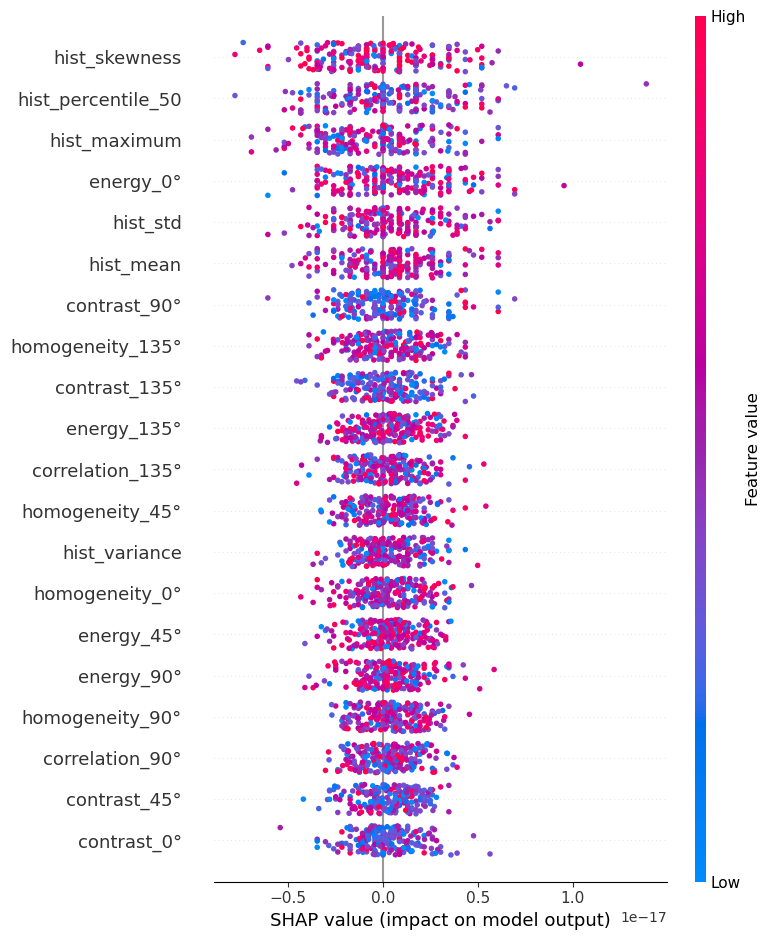

In [155]:

total_shap_values = np.zeros_like(shap_values_dict[list(shap_values_dict.keys())[0]])
total_count = 0

# Itera attraverso tutte le chiavi del dizionario di shap values
for key in shap_values_dict.keys():
    shap_values = shap_values_dict[key]
    total_shap_values += shap_values
    total_count += 1

avg_shap_values = total_shap_values / total_count
#print(avg_shap_values)
#print(np.array(avg_shap_values).shape)

# Crea uno shap summary plot utilizzando gli shap values medi
shap.summary_plot(np.mean(avg_shap_values, axis=0),features=x,  feature_names=feature_names)
plt.show()


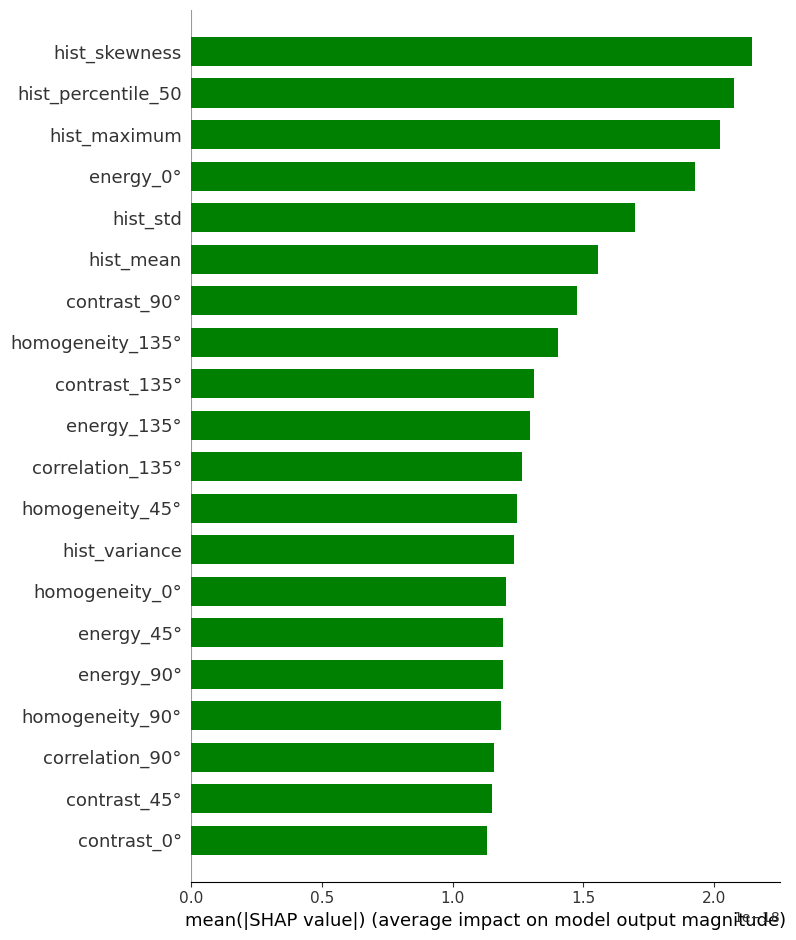

In [156]:
shap.summary_plot(np.mean(avg_shap_values, axis=0),features=x,  feature_names=feature_names,plot_type='bar',color='green')
plt.show()

- **Confusion Matrix**

In [178]:
avg_confusion_matrix = np.zeros((2, 2))

# Conta il numero totale di matrici di confusione
total_matrices = len(confusion_matrices)

# Somma tutte le matrici di confusione
for matrix in confusion_matrices.values():
    avg_confusion_matrix += matrix[0]  # Ogni elemento del dizionario contiene una lista con una singola matrice di confusione

# Calcola la matrice di confusione media dividendo per il numero totale di matrici
avg_confusion_matrix /= total_matrices

print("Matrice di confusione media:")
print(avg_confusion_matrix)

Matrice di confusione media:
[[95.17 69.83]
 [25.71 21.29]]


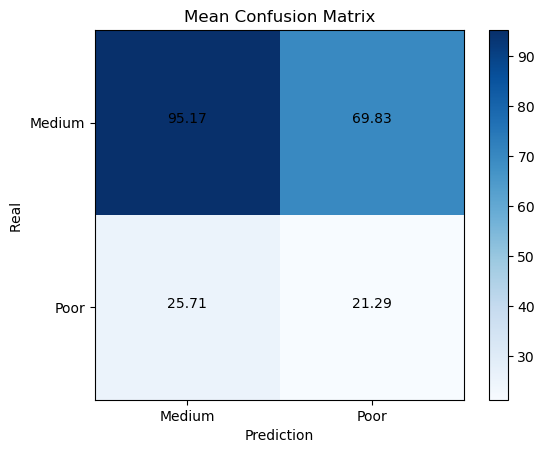

In [183]:
plt.imshow(avg_confusion_matrix, interpolation='nearest', cmap=plt.cm.Blues)
for i in range(2):
    for j in range(2):
        plt.text(j, i, str(round(avg_confusion_matrix[i, j], 2)), horizontalalignment="center", color="black")
plt.title('Mean Confusion Matrix')
plt.colorbar()
plt.xlabel('Prediction')
plt.ylabel('Real ')
plt.xticks(np.arange(2), ['Medium', 'Poor'])
plt.yticks(np.arange(2), ['Medium', 'Poor'])
plt.show()


In [186]:
# Calcola sensitivity e specificity

TP = avg_confusion_matrix[0, 0]  
FN = avg_confusion_matrix[0, 1]  
TN = avg_confusion_matrix[1, 1]  
FP = avg_confusion_matrix[1, 0]  

sensitivity = TP / (TP + FN)    
specificity = TN / (TN + FP)

print("Sensitivity:", sensitivity)
print("Specificity:", specificity)
    
   

Sensitivity: 0.5767878787878788
Specificity: 0.4529787234042553
